<a href="https://colab.research.google.com/github/DhrumilPrajapati03/Hyperparameter-tuning_of_U-NET/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Building and Training

In [2]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-fmbg_qg0
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-fmbg_qg0
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=b203be68fd23d9de581808ee6931f28ad4e8ac550fa2e04f58e9504fc855a034
  Stored in directory: /tmp/pip-ephem-wheel-cache-ap1v8f66/wheels/54/34/7f/b2b4efb59db0271239ccc6450d45591df6c415c7748d1b7650
Successfully built segmentation_models


In [3]:
#### [CONFIG] ####

# model training

epochs = 30

# dataset

tile_size = 64
#overlap = 0
overlap = 32

filter_enough_change = True
#change_pix_percent = 0.0 # has at least some change
#change_pix_percent = 0.1 # has at least 10% change (only 336 samples!)
change_pix_percent = 0.03 # has at least 3% change (1044 samples - might be actually good!)

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math
import sklearn.metrics
# all ch loading:
import shutil
from glob import glob
from skimage import io

from tqdm import tqdm
from pprint import pprint

In [5]:
img_dir = "/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Images"
test_dir = "/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Test Labels"
train_dir = "/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Train Labels"

In [7]:
train_cities = [name for name in os.listdir(train_dir) if os.path.isdir(train_dir+"/"+name)]
test_cities = [name for name in os.listdir(test_dir) if os.path.isdir(test_dir+"/"+name)]
print("train cities:", len(train_cities), "test cities:", len(test_cities))

train cities: 14 test cities: 10


In [8]:
def has_change(lab):
    num_ones = np.count_nonzero(lab.flatten() == 1.0)
    num_all_pixels = len(lab.flatten())
    perc_change = num_ones / num_all_pixels

    return perc_change > change_pix_percent
    #return np.max(lab) == 1.0

def tile_image(im1, im2, label, overlap_for_tiling = 0, filter_on = False):
    tiles_im1 = []
    tiles_im2 = []
    tiles_label = []

    move_by = tile_size - overlap_for_tiling

    image_shape = np.array(im1).shape
    h, w, ch = image_shape

    h_num = math.floor(h / tile_size)
    heights = [tile_size*i for i in range(h_num)]
    w_num = math.floor(w / tile_size)
    widths = [tile_size*i for i in range(w_num)]
    #print(h_num, heights)
    #print(w_num, widths)

    h_current = 0
    w_current = 0
    while h_current + tile_size < h:
        while w_current + tile_size < w:
            row_start = h_current
            row_end = h_current + tile_size
            col_start = w_current
            col_end = w_current + tile_size
            w_current += move_by

            tile_im1 = im1[row_start:row_end,col_start:col_end,:]
            tile_im2 = im2[row_start:row_end,col_start:col_end,:]
            tile_label = label[row_start:row_end,col_start:col_end,:]

            if not filter_on or has_change(tile_label):
                #print(tile_im1.shape, tile_im2.shape, tile_label.shape)
                tiles_im1.append(tile_im1)
                tiles_im2.append(tile_im2)
                tiles_label.append(tile_label)
        h_current += move_by
        w_current = 0

    tiles_im1 = np.asarray(tiles_im1)
    tiles_im2 = np.asarray(tiles_im2)
    tiles_label = np.asarray(tiles_label)
    return tiles_im1, tiles_im2, tiles_label

def dataset_from_folder(cities_folder, labels_folder, overlap_for_tiling=0, filter_on=False):
    # loading uses snippets from https://www.kaggle.com/aninda/change-detection-nb

    img1_paths = []   # creating list of imagery paths for first set of images
    img2_paths = []   # creating list of imagery paths for second set of images
    label_paths = []  # creating list of change mask paths for the images
    # load paths:
    for city in cities_folder:
        img1_paths.append(img_dir + "/" + city + "/pair/" + "img1.png") # < "pair" contains rgb only ...
        img2_paths.append(img_dir + "/" + city + "/pair/" + "img2.png")
        label_paths.append(labels_folder + "/" + city +"/cm/cm.png")

    # load images:
    all_tiles_im1 = []
    all_tiles_im2 = []
    all_tiles_label = []
    for img_idx in range(len(cities_folder)):
        im1 = Image.open(img1_paths[img_idx])
        im2 = Image.open(img2_paths[img_idx])
        lab = Image.open(label_paths[img_idx]).convert('L') # LA is with transparency

        im1 = np.array(im1) / 255 # scale
        im2 = np.array(im2) / 255 # scale
        lab = np.array(lab) / 255 # scale 0 or 1
        lab = lab.astype(np.uint8)
        lab = np.expand_dims(lab, axis=2)

        #print("debug same shapes >", im1.shape, im2.shape, lab.shape)
        #show_three(im1,im2,lab)

        print(img1_paths[img_idx],"~",img_idx,": A=", np.array(im1).shape,"B=",np.array(im2).shape,"L=",np.array(lab).shape)
        tiles_im1, tiles_im2, tiles_label = tile_image(im1, im2, lab, overlap_for_tiling, filter_on)
        print("Loaded triplets:", tiles_im1.shape, tiles_im2.shape, tiles_label.shape)

        if len(tiles_im1) > 0:
            # only if we didn't filter all out
            if len(all_tiles_im1)==0:
                all_tiles_im1 = tiles_im1
            else:
                all_tiles_im1 = np.vstack((all_tiles_im1, tiles_im1))
            if len(all_tiles_im2)==0:
                all_tiles_im2 = tiles_im2

            else:
                all_tiles_im2 = np.vstack((all_tiles_im2, tiles_im2))

            if len(all_tiles_label)==0:
                all_tiles_label = tiles_label
            else:
                all_tiles_label = np.vstack((all_tiles_label, tiles_label))

    all_tiles_im1 = np.asarray(all_tiles_im1)
    all_tiles_im2 = np.asarray(all_tiles_im2)
    all_tiles_label = np.asarray(all_tiles_label)
    all_triplets = [all_tiles_im1, all_tiles_im2, all_tiles_label]

    return all_triplets

In [9]:
train_triplets = dataset_from_folder(train_cities,train_dir, overlap_for_tiling=overlap, filter_on = filter_enough_change)
test_triplets = dataset_from_folder(test_cities,test_dir) # without overlap! and without filterings!

/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/beirut/pair/img1.png ~ 0 : A= (1180, 1070, 3) B= (1180, 1070, 3) L= (1180, 1070, 1)
Loaded triplets: (228, 64, 64, 3) (228, 64, 64, 3) (228, 64, 64, 1)
/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/saclay_e/pair/img1.png ~ 1 : A= (639, 688, 3) B= (639, 688, 3) L= (639, 688, 1)
Loaded triplets: (40, 64, 64, 3) (40, 64, 64, 3) (40, 64, 64, 1)
/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/nantes/pair/img1.png ~ 2 : A= (522, 582, 3) B= (522, 582, 3) L= (522, 582, 1)
Loaded triplets: (39, 64, 64, 3) (39, 64, 64, 3) (39, 64, 64, 1)
/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/hongkong/pair/img1.png ~ 3 : A= (695, 540, 3) B= (695, 540, 3) L= (695, 540, 1)
Loaded triplets: (73, 64, 64, 3) (73, 64, 64, 3) (73, 64, 64, 1)
/content/drive/MyDrive/OSCD_DATASET/Onera Satellite Change Detection da

In [10]:
print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)

Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)


Plotting all train_triplets

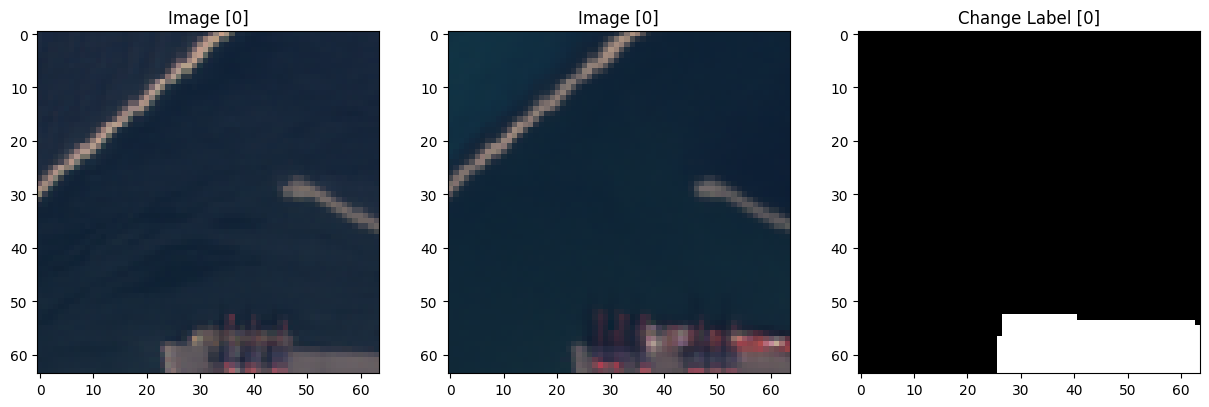

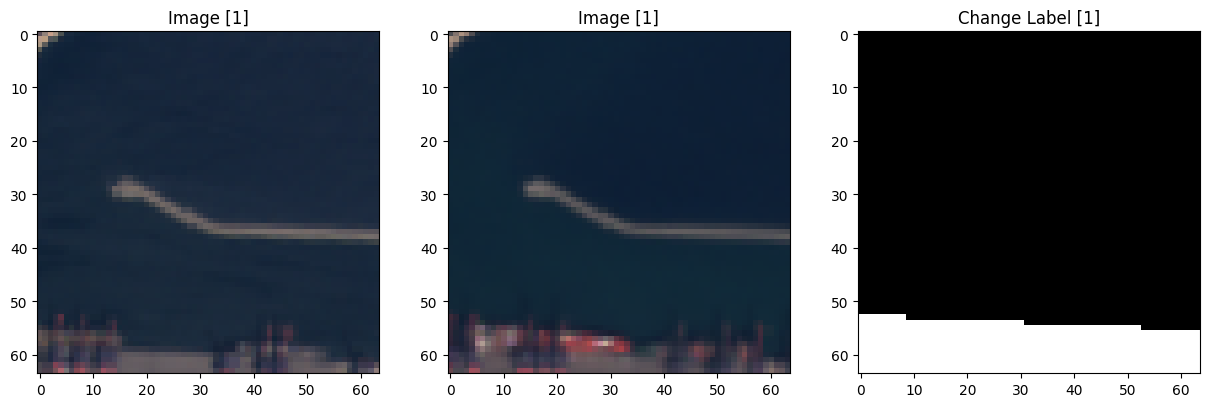

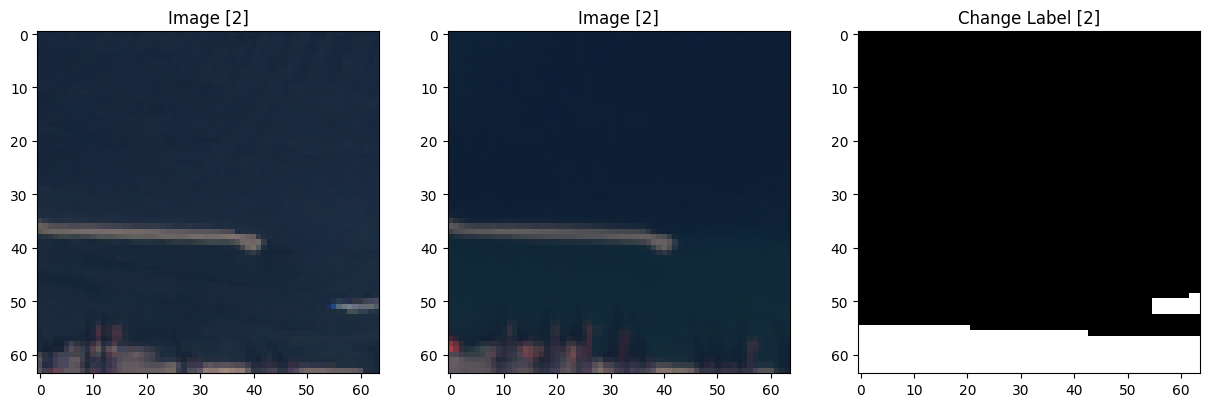

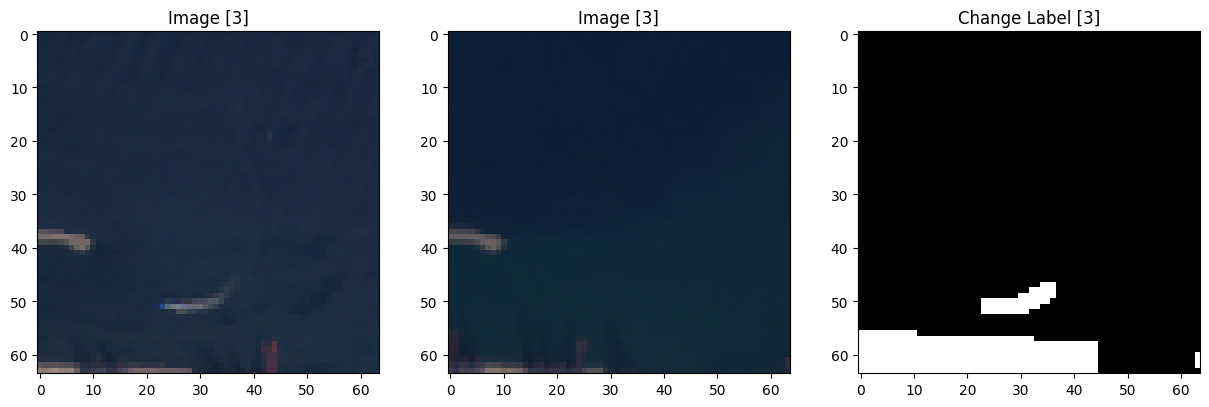

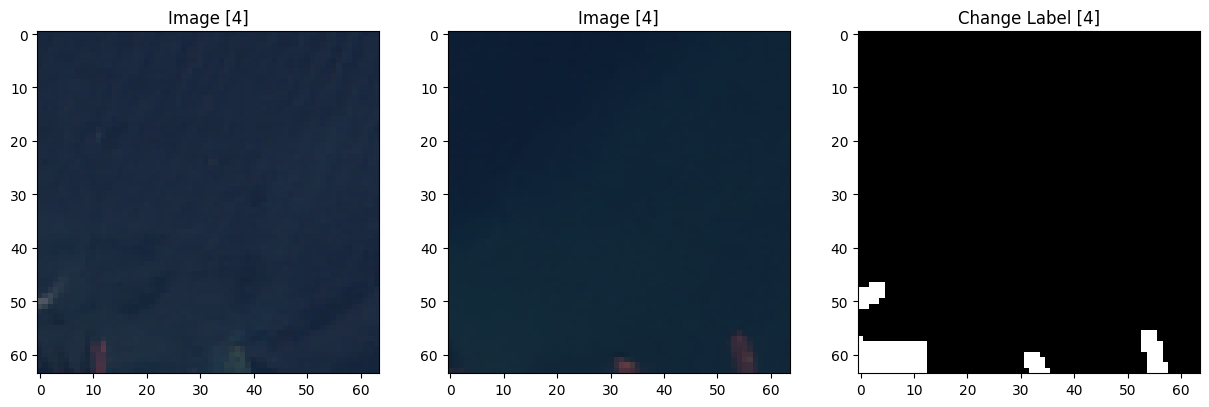

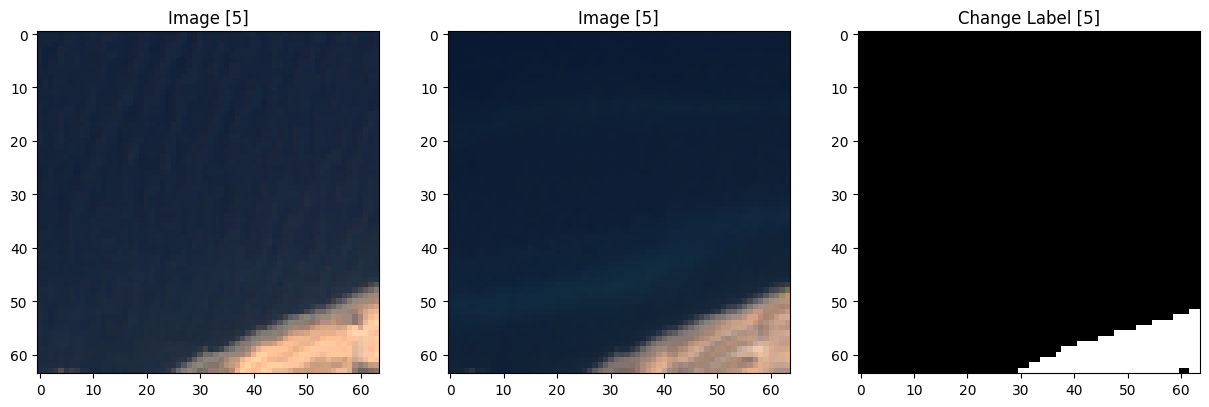

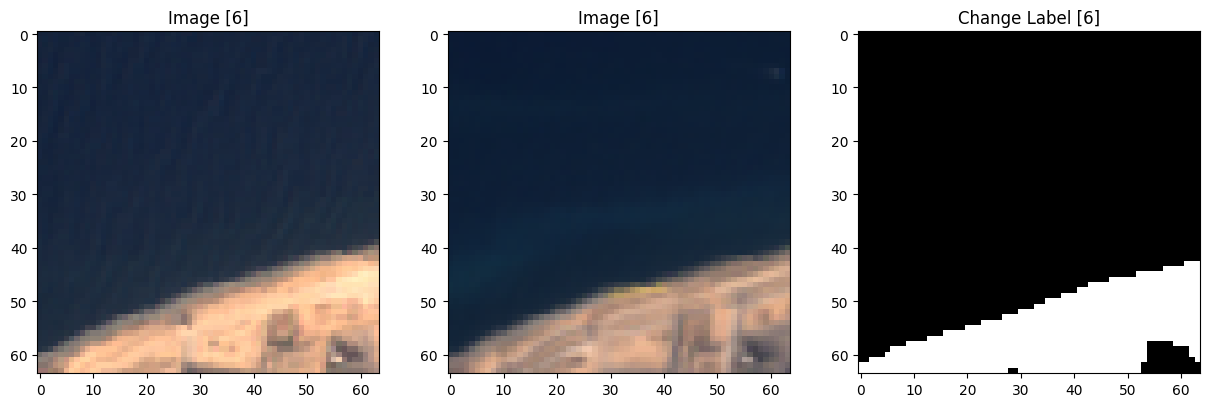

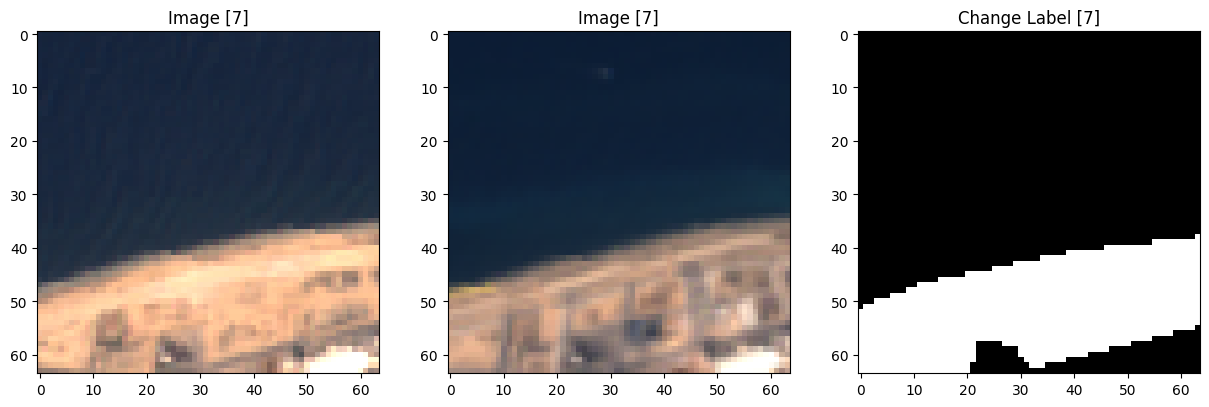

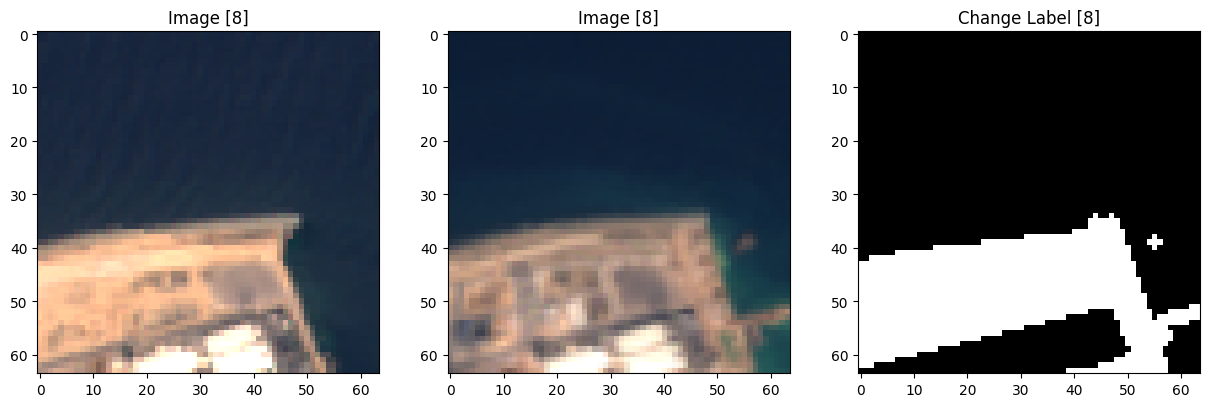

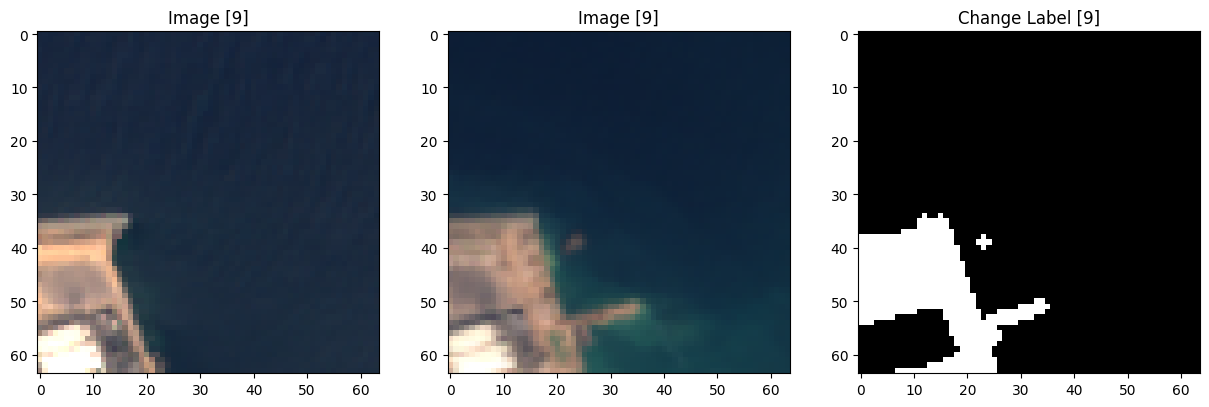

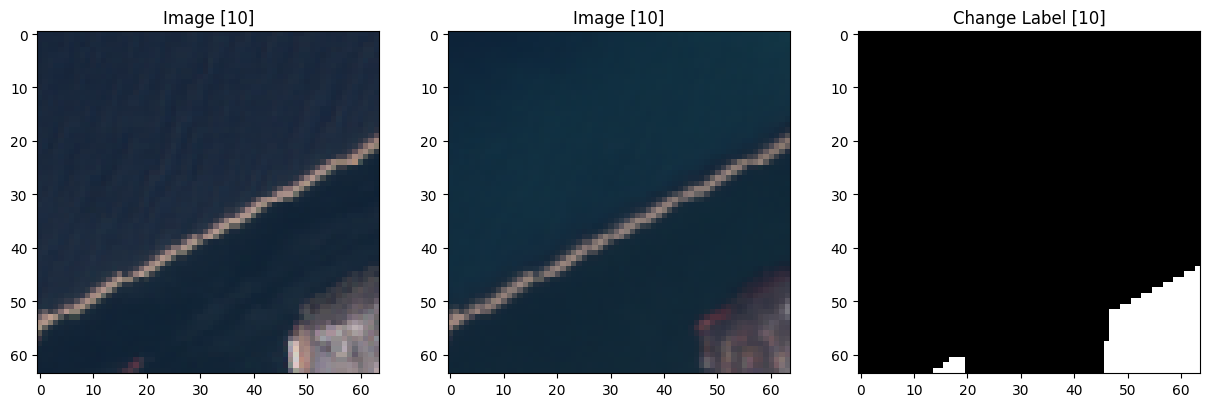

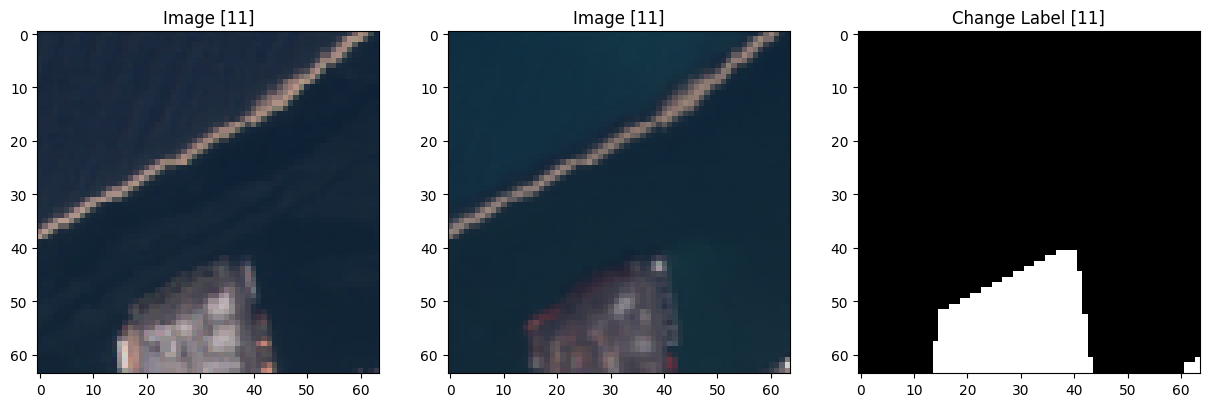

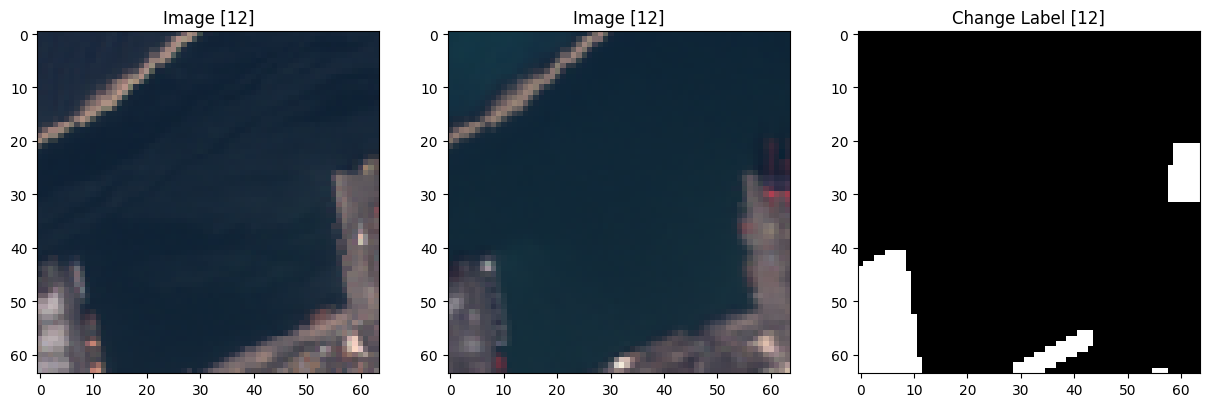

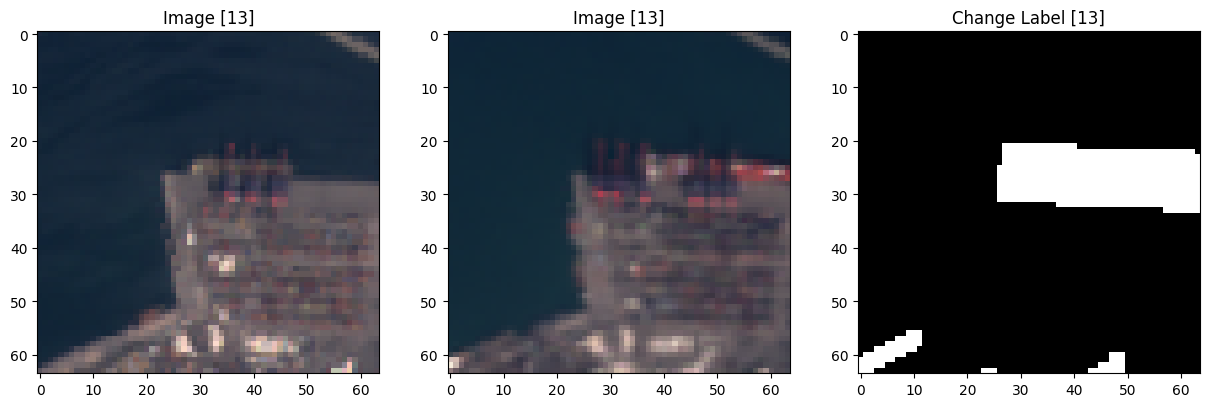

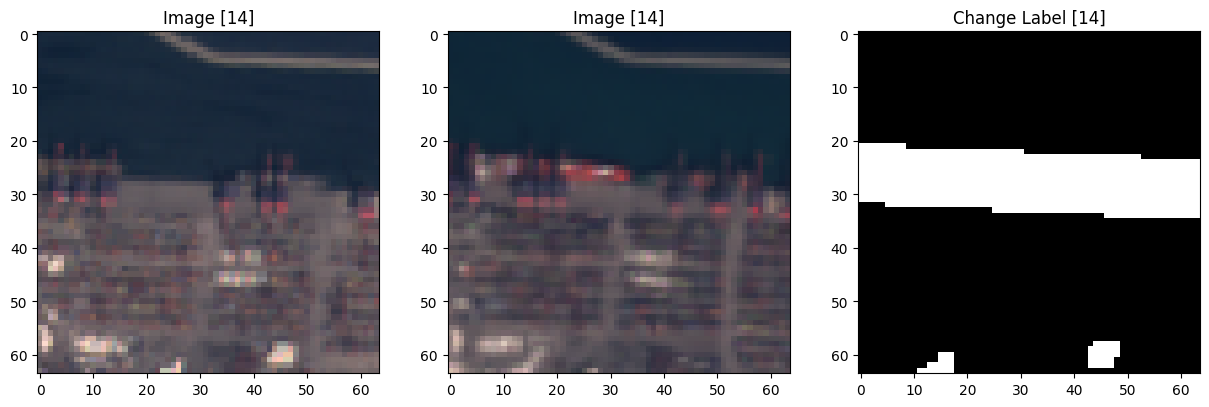

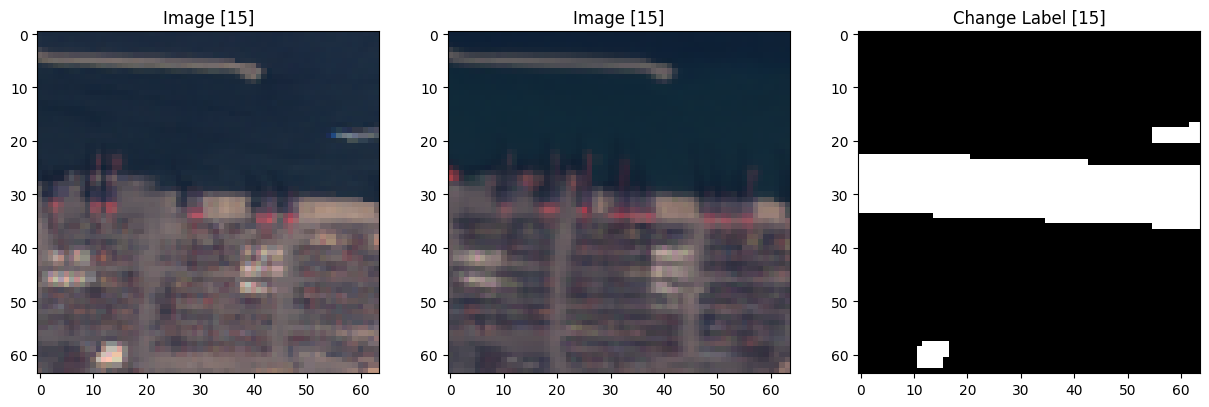

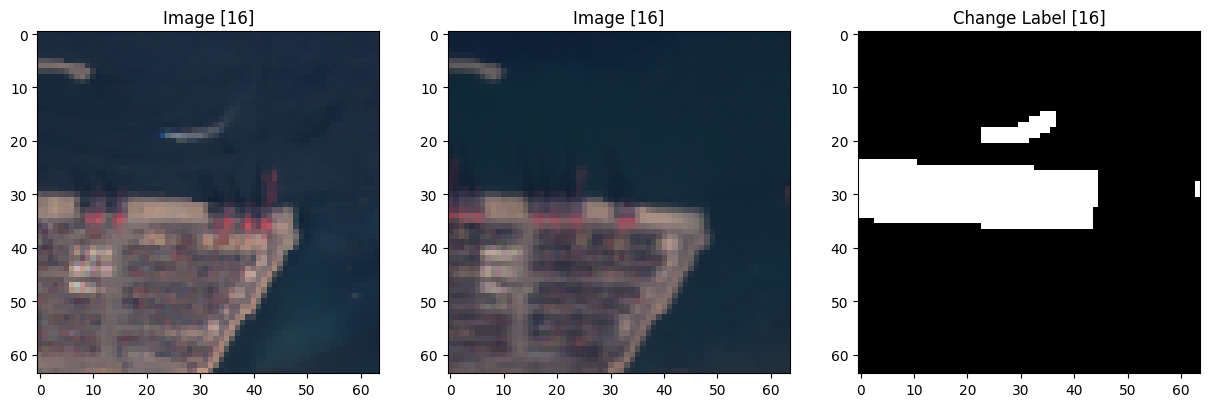

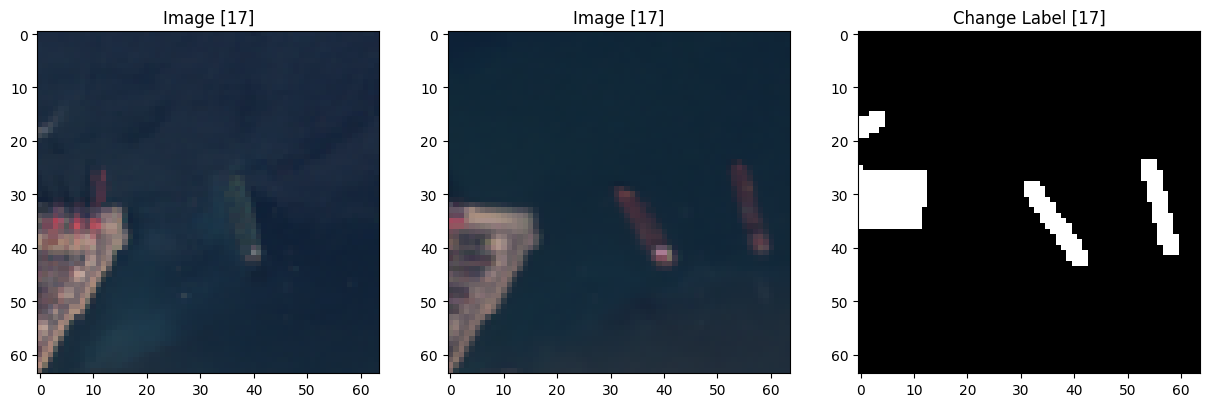

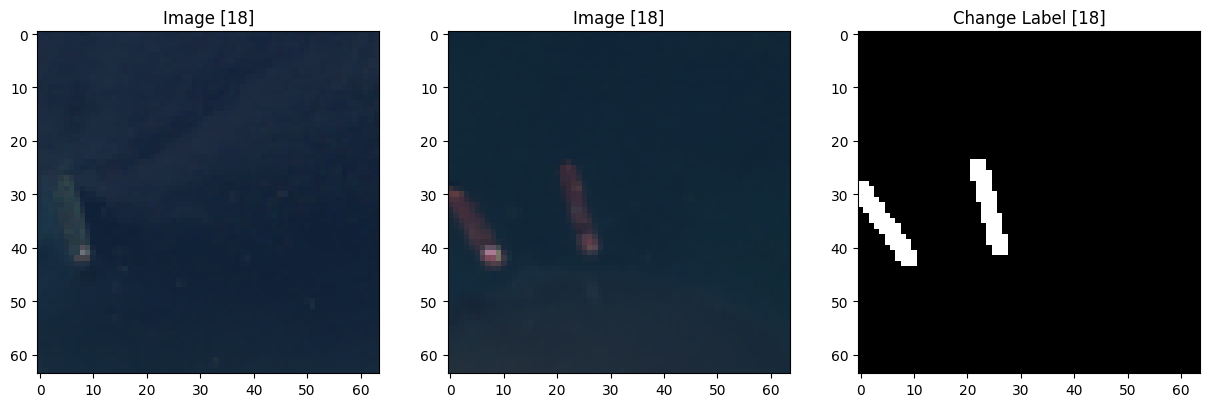

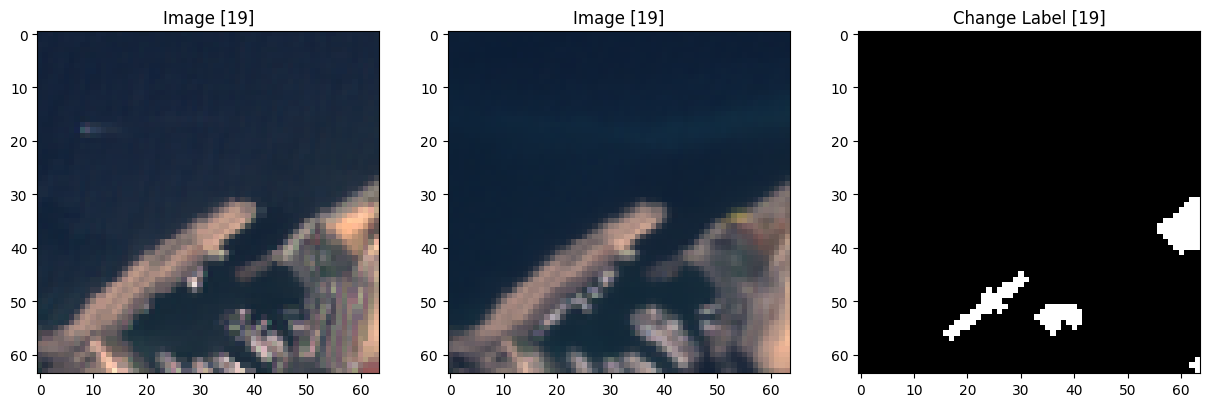

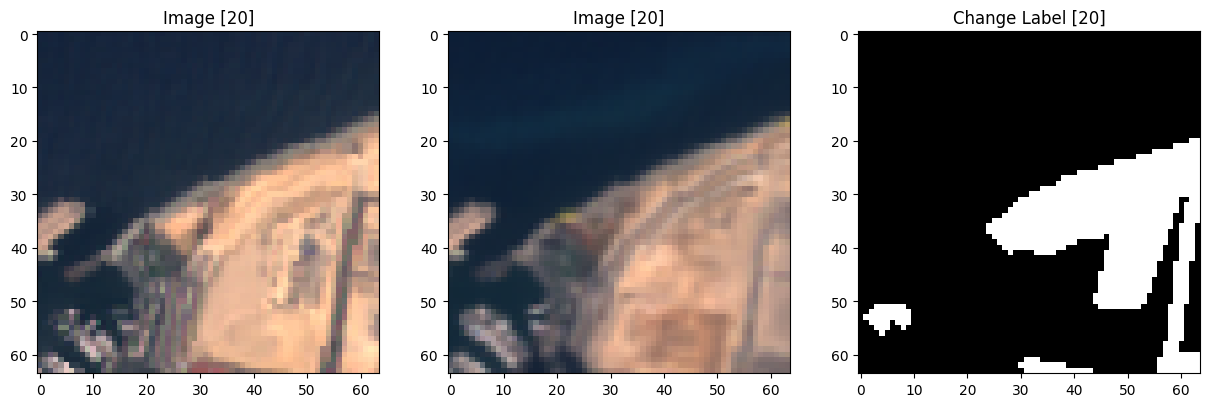

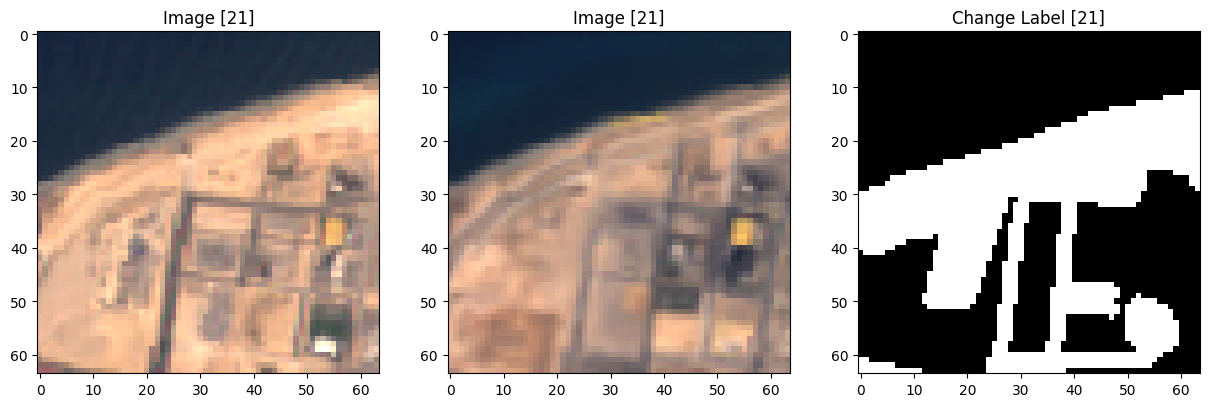

KeyboardInterrupt: 

In [ ]:
# prompt: plot all train_triplets

import matplotlib.pyplot as plt

# Assuming train_triplets[0], train_triplets[1], and train_triplets[2] contain image data
# Iterate through the triplets and plot each image pair with its label
for i in range(min(len(train_triplets[0]), 228)):  # Limiting to 5 plots for demonstration
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(train_triplets[0][i])
    axes[0].set_title(f"Image {[i]}")

    axes[1].imshow(train_triplets[1][i])
    axes[1].set_title(f"Image {[i]}")

    axes[2].imshow(train_triplets[2][i].squeeze(), cmap='gray')  # Assuming labels are grayscale
    axes[2].set_title(f"Change Label {[i]}")

    plt.show()


#519
0 1


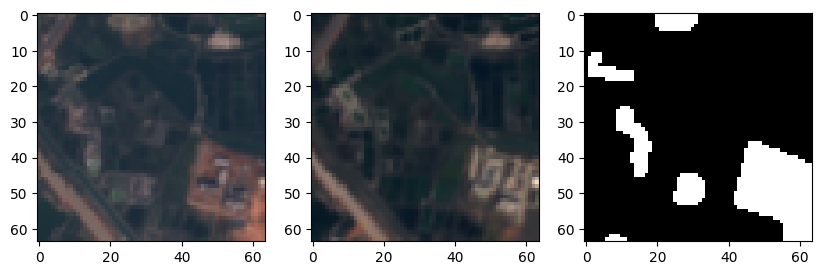

In [ ]:
def show_three(im1,im2,lab):
    fig,ax = plt.subplots(1,3,figsize=(10,10))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(lab[:,:,0], cmap='gray')

def show_four(im1,im2,lab,pred):
    fig,ax = plt.subplots(1,4,figsize=(10,10))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(lab[:,:,0], cmap='gray')
    ax[3].imshow(pred[:,:,0], cmap='gray')

def random_from_triplet(triplets):
    sample = np.random.randint(0,len(triplets[0]))
    print("#"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    #im1.shape,im2.shape,target.shape
    return im1,im2,lab

def show_rand_tripplet(triplets):
    im1,im2,lab = random_from_triplet(triplets)
    show_three(im1,im2,lab)
    print(np.min(lab), np.max(lab))

show_rand_tripplet(train_triplets)

Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
#266
0 1
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)
#230
0 1


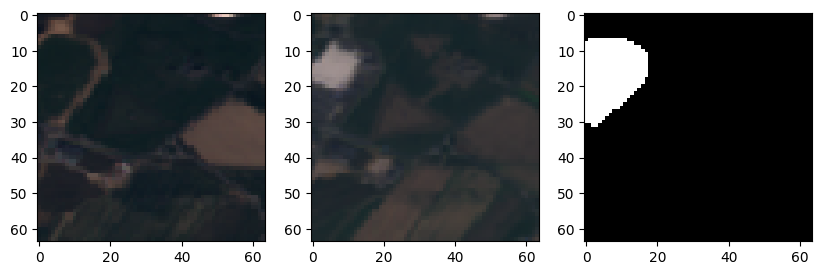

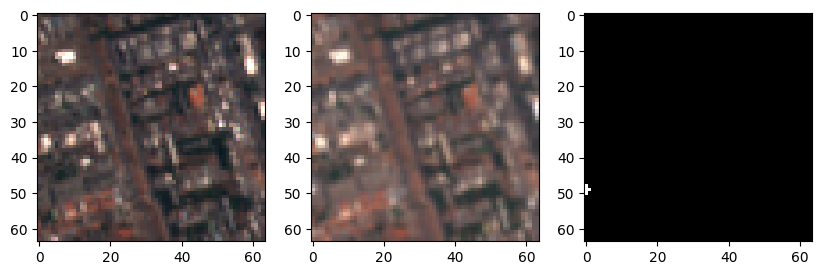

In [ ]:
# Train
print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
show_rand_tripplet(train_triplets)
#Test
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)
show_rand_tripplet(test_triplets)

In [ ]:
import segmentation_models as sm
#import keras
from tensorflow import keras

sm.set_framework('tf.keras') # for Collab ~
sm.framework()

keras.backend.set_image_data_format('channels_last')

In [ ]:
# Dataset:
## train_triplets, test_triplets => x_train, y_train, x_val, y_val

# dummy approach pixel differencing at the input!

def keras_dataset_differencingPixels(triplets):
    # input triples
    # outputs x, y
    train_im1, train_im2, train_labels = triplets
    print("in", train_im1.shape, train_im2.shape, train_labels.shape)

    x = train_im1 - train_im2
    y = train_labels

    x = x.astype(np.float32)
    y = y.astype(np.float32)
    print("out", x.shape, y.shape, "types:", x.dtype, y.dtype)
    return x, y

x_train, y_train = keras_dataset_differencingPixels(train_triplets)
x_val, y_val = keras_dataset_differencingPixels(test_triplets)

in (1044, 64, 64, 3) (1044, 64, 64, 3) (1044, 64, 64, 1)
out (1044, 64, 64, 3) (1044, 64, 64, 1) types: float32 float32
in (663, 64, 64, 3) (663, 64, 64, 3) (663, 64, 64, 1)
out (663, 64, 64, 3) (663, 64, 64, 1) types: float32 float32


In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

model.save("model2.keras")

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 76s 506ms/step - auc: 0.7306 - iou_score: 0.1569 - loss: 1.2868 - val_auc: 0.4890 - val_iou_score: 0.0344 - val_loss: 1.2415
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step - auc: 0.8846 - iou_score: 0.3117 - loss: 0.9218 - val_auc: 0.4745 - val_iou_score: 0.0102 - val_loss: 1.2972
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - auc: 0.9222 - iou_score: 0.3972 - loss: 0.8203 - val_auc: 0.4998 - val_iou_score: 0.0106 - val_loss: 2.0336
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - auc: 0.9337 - iou_score: 0.4454 - loss: 0.7571 - val_auc: 0.4978 - val_iou_score: 0.0019 - val_loss: 1.4063
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - auc: 0.9426 - iou_score: 0.4877 - loss: 0.6899 - val_auc: 0.4986 - val_iou_score: 9.5829e-04 - val_loss: 1.4044
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - auc: 0.9408 - iou_score: 0.5079 - loss: 0.6712 - val_auc: 0.4992 - val_iou_score: 6.0427e-04 - val_loss: 1.4519
Epoch 7/30
66/66 ━━━━━━

In [ ]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)

    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

#597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction visualization


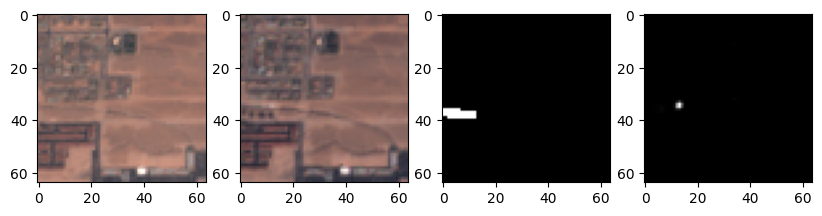

In [ ]:
# prompt: show_four(im1,im2,lab,y_pred) plot this

predict_with_model_rand(test_triplets)

In [ ]:
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_52   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_5… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_53   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_54   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_5… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, None,      │          0 │ stage1_unit1_bn3

 Total params: 97,588,228 (372.27 MB)

 Trainable params: 32,513,556 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

 Optimizer params: 65,027,114 (248.06 MB)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
h = history.history
print(history.history.keys())

NameError: name 'history' is not defined

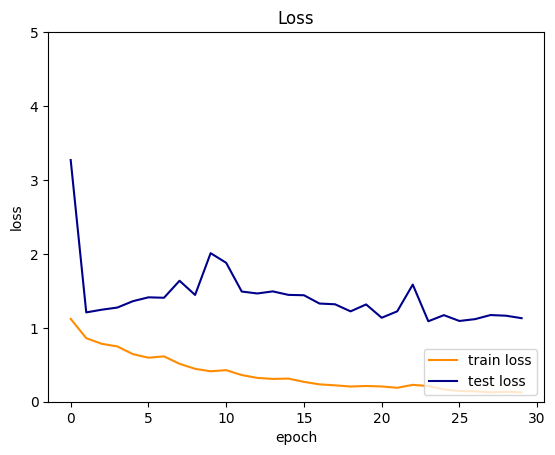

In [ ]:
plt.figure()
plt.plot(h['loss'], color='darkorange', label='train loss')
plt.plot(h['val_loss'], color='darkblue', label='test loss')
plt.ylim(0,5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_loss.png")
#plt.close()

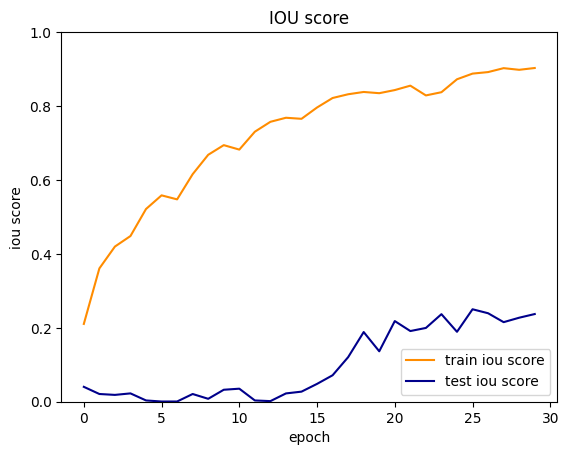

In [ ]:
plt.figure()
plt.plot(h['iou_score'], color='darkorange', label='train iou score')
plt.plot(h['val_iou_score'], color='darkblue', label='test iou score')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('iou score')
plt.title('IOU score')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_iou.png")
#plt.close()


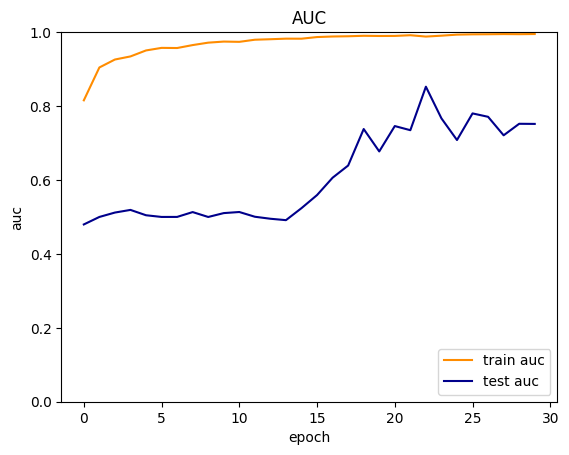

In [ ]:
plt.figure()
plt.plot(h['auc'], color='darkorange', label='train auc')
plt.plot(h['val_auc'], color='darkblue', label='test auc')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('auc')
plt.title('AUC')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist.png")
#plt.close()

#462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction visualization
#359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction visualization
#291
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction visualization
#451
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction visualization


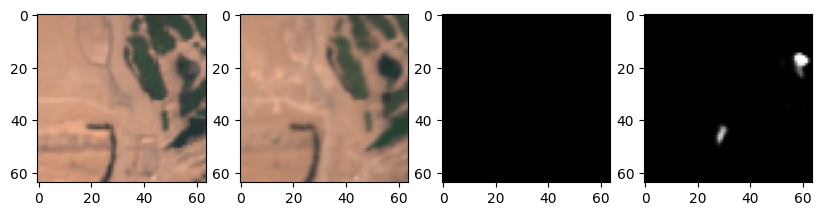

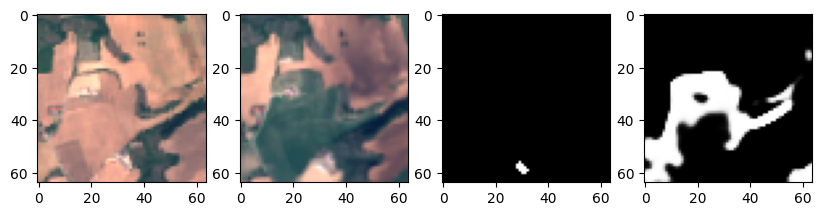

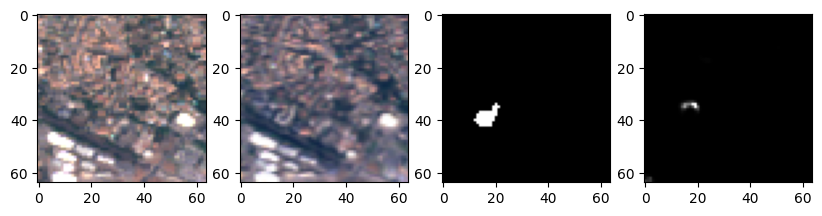

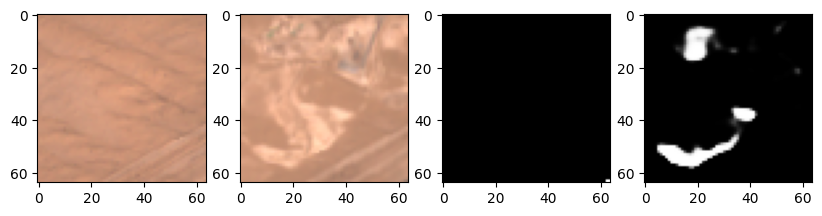

In [ ]:
for _ in range(4):
  predict_with_model_rand(test_triplets)
  #predict_with_model_rand(train_triplets)

In [ ]:
def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1

<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-40-c62769732017>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if save_text_file is not "":


In [ ]:
def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets

    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)

    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step


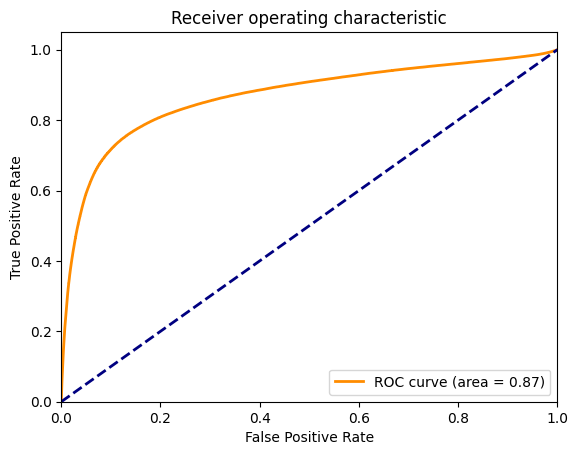

Finished with AUC (test set) = 0.8668032991973834
              precision    recall  f1-score   support

   no change       0.97      0.98      0.97   2569623
      change       0.53      0.38      0.45    146025

    accuracy                           0.95   2715648
   macro avg       0.75      0.68      0.71   2715648
weighted avg       0.94      0.95      0.94   2715648

[[2520562   49061]
 [  90166   55859]]
saving to... test.txt
Recall 0.38253038863208355 Prec 0.5323961113229126 Acc 0.9487315734587104 F1 0.4451891848811493
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step


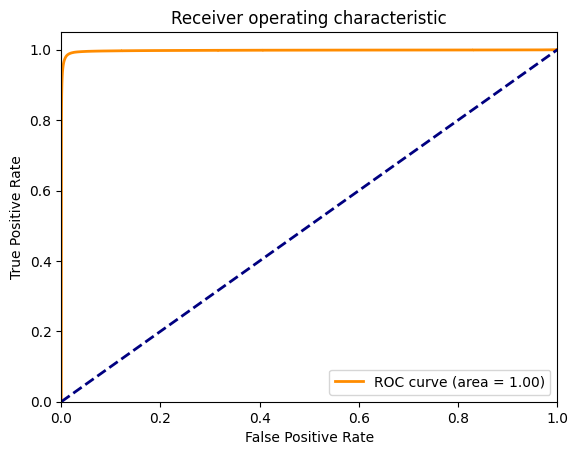

Finished with AUC (train set) = 0.9977167171077677
              precision    recall  f1-score   support

   no change       0.99      1.00      1.00   3826130
      change       0.97      0.95      0.96    450094

    accuracy                           0.99   4276224
   macro avg       0.98      0.97      0.98   4276224
weighted avg       0.99      0.99      0.99   4276224

[[3813834   12296]
 [  23184  426910]]
saving to... train.txt
Recall 0.9484907597079721 Prec 0.9720040254459184 Acc 0.9917029603687739 F1 0.9601034521533791


In [ ]:
predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

# Hyper-parameter tuning

## Model Architecture Enhancement

### 1) Backbone

#### Resnet50

In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_52   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_5… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_53   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_54   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_5… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, None,      │          0 │ stage1_unit1_bn3

 Total params: 32,561,114 (124.21 MB)

 Trainable params: 32,513,556 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

model.save("model3.keras")

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 97s 592ms/step - auc_2: 0.7428 - iou_score: 0.1399 - loss: 1.4287 - val_auc_2: 0.4996 - val_iou_score: 0.0127 - val_loss: 2.1037
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - auc_2: 0.8782 - iou_score: 0.2753 - loss: 0.9766 - val_auc_2: 0.4909 - val_iou_score: 0.0276 - val_loss: 1.1904
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - auc_2: 0.9020 - iou_score: 0.3440 - loss: 0.8790 - val_auc_2: 0.5012 - val_iou_score: 0.0113 - val_loss: 1.2250
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - auc_2: 0.9300 - iou_score: 0.4151 - loss: 0.7892 - val_auc_2: 0.5355 - val_iou_score: 0.0047 - val_loss: 1.2805
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - auc_2: 0.9343 - iou_score: 0.4421 - loss: 0.7522 - val_auc_2: 0.4952 - val_iou_score: 0.0039 - val_loss: 1.2910
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - auc_2: 0.9468 - iou_score: 0.4920 - loss: 0.6816 - val_auc_2: 0.4981 - val_iou_score: 0.0021 - val_loss: 1.3296
Epoch

#397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction visualization


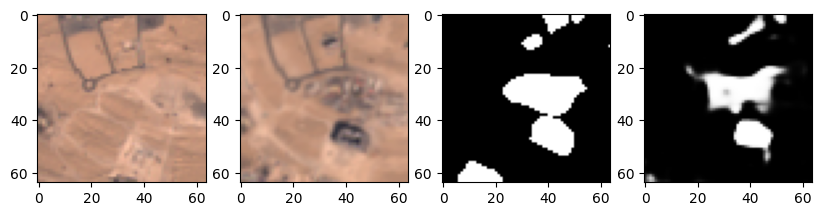

In [ ]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)

    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

# prompt: show_four(im1,im2,lab,y_pred) plot this

predict_with_model_rand(test_triplets)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)
model.summary()

h = history.history
print(history.history.keys())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_52   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_5… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_53   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_54   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_5… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, None,      │          0 │ stage1_unit1_bn3

 Total params: 97,588,228 (372.27 MB)

 Trainable params: 32,513,556 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

 Optimizer params: 65,027,114 (248.06 MB)

dict_keys(['auc_2', 'iou_score', 'loss', 'val_auc_2', 'val_iou_score', 'val_loss'])


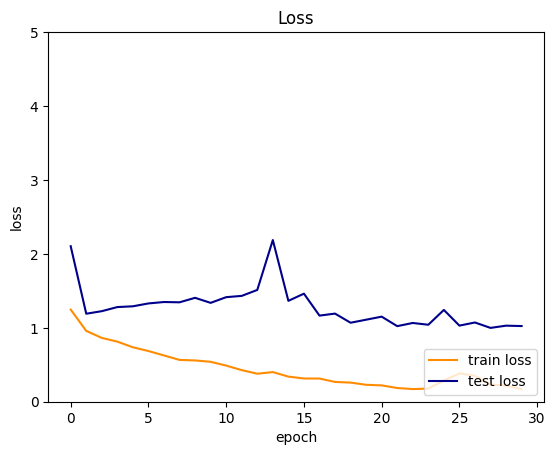

In [ ]:
plt.figure()
plt.plot(h['loss'], color='darkorange', label='train loss')
plt.plot(h['val_loss'], color='darkblue', label='test loss')
plt.ylim(0,5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_loss.png")
#plt.close()

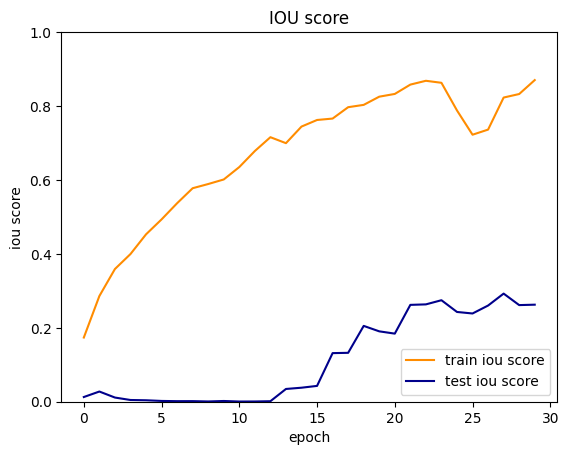

In [ ]:
plt.figure()
plt.plot(h['iou_score'], color='darkorange', label='train iou score')
plt.plot(h['val_iou_score'], color='darkblue', label='test iou score')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('iou score')
plt.title('IOU score')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_iou.png")
#plt.close()


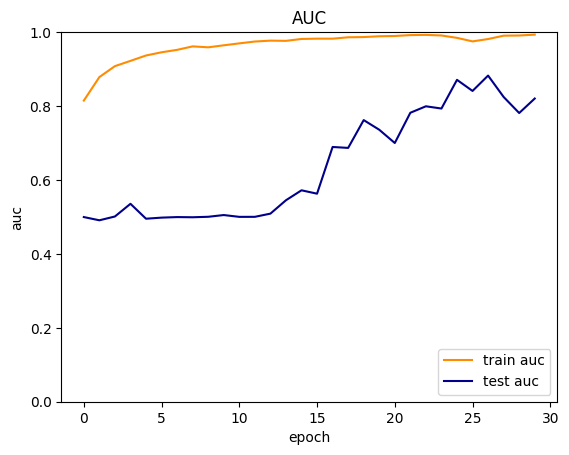

In [ ]:
plt.figure()
plt.plot(h['auc_2'], color='darkorange', label='train auc')
plt.plot(h['val_auc_2'], color='darkblue', label='test auc')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('auc')
plt.title('AUC')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist.png")
#plt.close()

In [ ]:
def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1

<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-37-c62769732017>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if save_text_file is not "":


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step


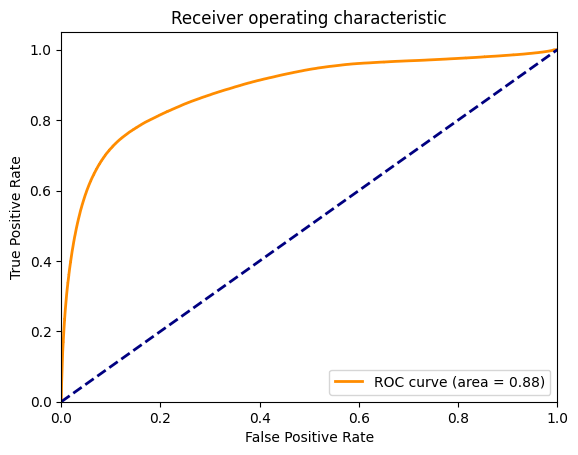

Finished with AUC (test set) = 0.8845405436289878
              precision    recall  f1-score   support

   no change       0.97      0.97      0.97   2569623
      change       0.48      0.50      0.49    146025

    accuracy                           0.94   2715648
   macro avg       0.72      0.73      0.73   2715648
weighted avg       0.94      0.94      0.94   2715648

[[2489537   80086]
 [  73384   72641]]
saving to... test.txt
Recall 0.4974559150830337 Prec 0.475626444571032 Acc 0.9434867847379337 F1 0.4862963260497001
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step


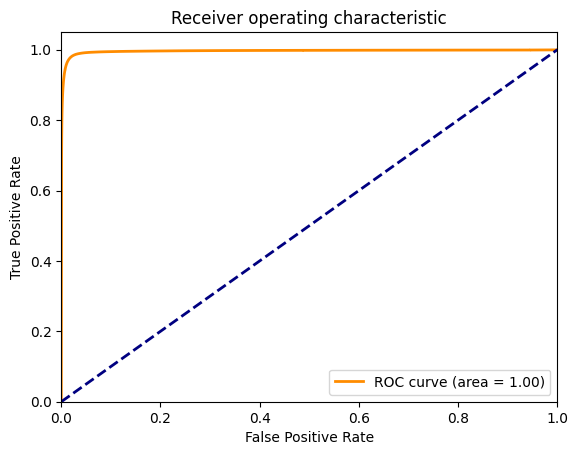

Finished with AUC (train set) = 0.996054947866404
              precision    recall  f1-score   support

   no change       0.99      0.99      0.99   3826130
      change       0.95      0.93      0.94    450094

    accuracy                           0.99   4276224
   macro avg       0.97      0.96      0.97   4276224
weighted avg       0.99      0.99      0.99   4276224

[[3802557   23573]
 [  30936  419158]]
saving to... train.txt
Recall 0.9312676907490436 Prec 0.9467554790606486 Acc 0.9872530063906849 F1 0.9389477221179963


In [ ]:
def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets

    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)

    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

#### Resnet101

In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet101'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

model.save("model4.keras")

171164896/171164896 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_70   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_7… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_71   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_72   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_7… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, None,      │          0 │ stage1_unit1_bn3

 Total params: 51,605,466 (196.86 MB)

 Trainable params: 51,505,684 (196.48 MB)

 Non-trainable params: 99,782 (389.77 KB)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 150s 871ms/step - auc_3: 0.7626 - iou_score: 0.1734 - loss: 1.1841 - val_auc_3: 0.5092 - val_iou_score: 0.0475 - val_loss: 1.6361
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - auc_3: 0.9027 - iou_score: 0.3405 - loss: 0.8904 - val_auc_3: 0.5003 - val_iou_score: 0.0536 - val_loss: 12.8423
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - auc_3: 0.9146 - iou_score: 0.3658 - loss: 0.8528 - val_auc_3: 0.5022 - val_iou_score: 0.0536 - val_loss: 12.7442
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - auc_3: 0.9262 - iou_score: 0.3971 - loss: 0.8088 - val_auc_3: 0.4998 - val_iou_score: 0.0013 - val_loss: 1.3598
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - auc_3: 0.9390 - iou_score: 0.4476 - loss: 0.7474 - val_auc_3: 0.5113 - val_iou_score: 0.0487 - val_loss: 3.8811
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - auc_3: 0.9482 - iou_score: 0.4976 - loss: 0.6728 - val_auc_3: 0.5000 - val_iou_score: 0.0012 - val_loss: 1.362

#217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction visualization


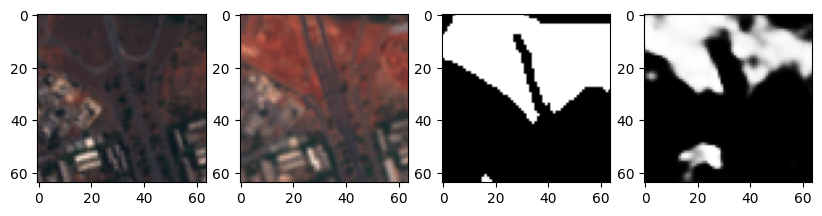

In [ ]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)

    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

# prompt: show_four(im1,im2,lab,y_pred) plot this

predict_with_model_rand(test_triplets)

In [ ]:
def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1

<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-47-c62769732017>:53: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if save_text_file is not "":


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step


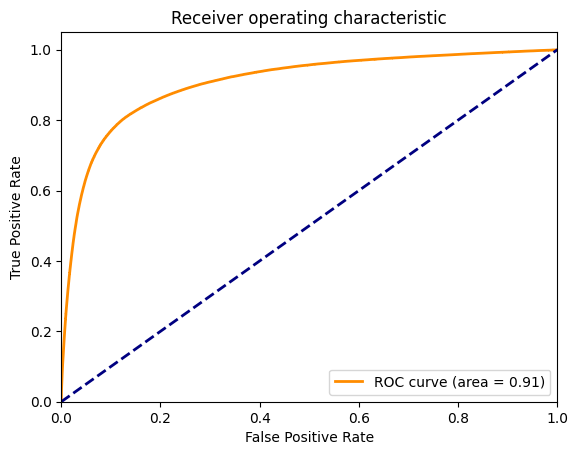

Finished with AUC (test set) = 0.9059533946331566
              precision    recall  f1-score   support

   no change       0.97      0.97      0.97   2569623
      change       0.51      0.48      0.49    146025

    accuracy                           0.95   2715648
   macro avg       0.74      0.73      0.73   2715648
weighted avg       0.95      0.95      0.95   2715648

[[2501885   67738]
 [  76424   69601]]
saving to... test.txt
Recall 0.4766375620612909 Prec 0.5067824871303854 Acc 0.9469143276300905 F1 0.4912480060981635
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step


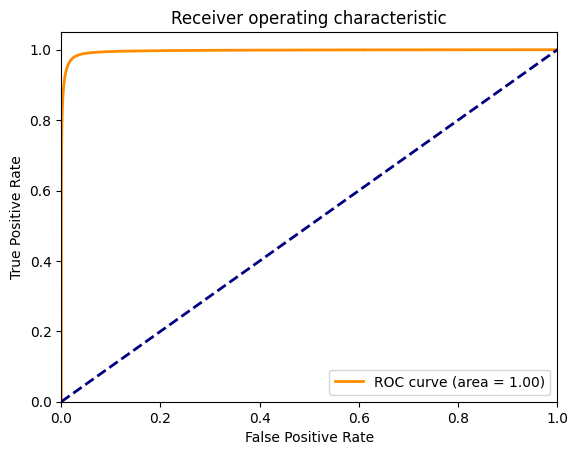

Finished with AUC (train set) = 0.9964430319845504
              precision    recall  f1-score   support

   no change       0.99      1.00      0.99   3826130
      change       0.96      0.89      0.92    450094

    accuracy                           0.98   4276224
   macro avg       0.97      0.94      0.96   4276224
weighted avg       0.98      0.98      0.98   4276224

[[3809768   16362]
 [  51618  398476]]
saving to... train.txt
Recall 0.885317289277351 Prec 0.9605580973777715 Acc 0.9841027972341954 F1 0.921404225996957


In [ ]:
def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets

    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)

    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

#### EfficientNet

In [ ]:
import segmentation_models as sm

BACKBONE = 'efficientnetb1'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

model.save("model5.keras")

258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,728 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 64)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      2,048 │ block1a_se_excit… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │        128 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_dwconv      │ (None, None,      │        288 │ block1a_project_… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_bn          │ (None, None,      │        128 │ block1b_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_activation  │ (None, None,      │          0 │ block1b_bn[0][0]

 Total params: 75,048,097 (286.29 MB)

 Trainable params: 74,735,393 (285.09 MB)

 Non-trainable params: 312,704 (1.19 MB)

Epoch 1/30


### 2) U-net++

In [ ]:
!pip uninstall albumentations

Found existing installation: albumentations 2.0.6
Uninstalling albumentations-2.0.6:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/albumentations-2.0.6.dist-info/*
    /usr/local/lib/python3.11/dist-packages/albumentations/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
                        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/req/req_uninstall.py", line 364, in remove
    if auto_confirm or self._allowed_to_proceed(verbose

In [ ]:
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import albumentations as A
from albumentations import ToTensorV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
# Set up environment
sm.set_framework('tf.keras')
BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 60
IMAGE_SIZE = 64
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [ ]:
# Custom Focal Tversky Loss Implementation
def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    true_pos = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])

    tversky_index = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return tf.reduce_mean(tf.pow((1 - tversky_index), gamma))

# Loss and Metrics
loss = focal_tversky_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
# Data Augmentation
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(p=0.2),
    A.GaussNoise(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
def load_data():
    # Placeholder function — replace with your own logic
    # Should return: x_train, x_val, y_train, y_val as numpy arrays
    return x_train, x_val, y_train, y_val

In [ ]:
# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

NameError: name 'preprocess_input' is not defined

In [ ]:
# Model definition
model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
    input_shape=INPUT_SHAPE,
    classes=1,
    activation='sigmoid'
)
model.compile(optimizer='adam', loss=loss, metrics=metrics)

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
]

In [ ]:
# Training
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save final model
model.save('final_model.h5')

Epoch 1/60


KeyboardInterrupt: 

## Augmentation

### Learning rate schedular

### Post-processing

### Hyperparameter Optimization

### Cross Validation

In [ ]:
from sklearn.model_selection import KFold
import segmentation_models as sm

def load_data():
    """
    Combines the training and validation data to create the full dataset for cross-validation.

    Returns:
        Tuple: A tuple containing the full dataset (x) and the corresponding labels (y).
    """
    # Concatenate training and validation data
    x = np.concatenate([x_train, x_val], axis=0)
    y = np.concatenate([y_train, y_val], axis=0)

    return x, y

# Load your full dataset
x, y = load_data()

BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 60
IMAGE_SIZE = 64
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Custom Focal Tversky Loss Implementation
def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    true_pos = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])

    tversky_index = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return tf.reduce_mean(tf.pow((1 - tversky_index), gamma))

# Loss and Metrics
loss = focal_tversky_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Define K-Fold Cross Validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(x):
    print(f"\n--- Fold {fold} ---")

    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Preprocess inputs
    x_train = preprocess_input(x_train)
    x_val = preprocess_input(x_val)

    # Define model inside the loop so it's fresh each fold
    model = sm.Unet(
        BACKBONE,
        encoder_weights='imagenet',
        input_shape=INPUT_SHAPE,
        classes=1,
        activation='sigmoid'
    )
    model.compile(optimizer='adam', loss=loss, metrics=metrics)

    # Define callbacks with fold-specific filenames
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'best_model_fold{fold}.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    # Train
    model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    # Save final model
    model.save(f'final_model_fold{fold}.h5')
    fold += 1



--- Fold 1 ---
Epoch 1/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - f1-score: 0.1661 - iou_score: 0.0915 - loss: 0.8484
Epoch 1: val_loss improved from inf to 0.84643, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 158s 795ms/step - f1-score: 0.1659 - iou_score: 0.0914 - loss: 0.8484 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8464 - learning_rate: 0.0010
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1525 - iou_score: 0.0834 - loss: 0.8442
Epoch 2: val_loss improved from 0.84643 to 0.84170, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - f1-score: 0.1525 - iou_score: 0.0834 - loss: 0.8441 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8417 - learning_rate: 0.0010
Epoch 3/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1506 - iou_score: 0.0821 - loss: 0.8436
Epoch 3: val_loss improved from 0.84170 to 0.83967, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1507 - iou_score: 0.0822 - loss: 0.8435 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8397 - learning_rate: 0.0010
Epoch 4/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1598 - iou_score: 0.0872 - loss: 0.8356
Epoch 4: val_loss improved from 0.83967 to 0.83921, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - f1-score: 0.1598 - iou_score: 0.0872 - loss: 0.8357 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8392 - learning_rate: 0.0010
Epoch 5/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1541 - iou_score: 0.0841 - loss: 0.8417
Epoch 5: val_loss improved from 0.83921 to 0.83900, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - f1-score: 0.1541 - iou_score: 0.0841 - loss: 0.8416 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8390 - learning_rate: 0.0010
Epoch 6/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1514 - iou_score: 0.0825 - loss: 0.8438
Epoch 6: val_loss improved from 0.83900 to 0.83863, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1515 - iou_score: 0.0826 - loss: 0.8437 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 0.0010
Epoch 7/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1592 - iou_score: 0.0870 - loss: 0.8362
Epoch 7: val_loss did not improve from 0.83863
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - f1-score: 0.1592 - iou_score: 0.0870 - loss: 0.8362 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8387 - learning_rate: 0.0010
Epoch 8/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1509 - iou_score: 0.0822 - loss: 0.8426
Epoch 8: val_loss did not improve from 0.83863
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - f1-score: 0.1510 - iou_score: 0.0822 - loss: 0.8425 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8387 - learning_rate: 0.0010
Epoch 9/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1570 - iou_score: 0.0858 - loss: 0.8390
Epoch 9: ReduceLROnPlateau reducing lea

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - f1-score: 0.1570 - iou_score: 0.0857 - loss: 0.8390 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 0.0010
Epoch 10/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1629 - iou_score: 0.0892 - loss: 0.8323
Epoch 10: val_loss improved from 0.83858 to 0.83857, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1628 - iou_score: 0.0891 - loss: 0.8324 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 5.0000e-04
Epoch 11/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1536 - iou_score: 0.0838 - loss: 0.8417
Epoch 11: val_loss improved from 0.83857 to 0.83856, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1536 - iou_score: 0.0838 - loss: 0.8416 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 5.0000e-04
Epoch 12/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1491 - iou_score: 0.0811 - loss: 0.8453
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: val_loss improved from 0.83856 to 0.83856, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - f1-score: 0.1492 - iou_score: 0.0812 - loss: 0.8451 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 5.0000e-04
Epoch 13/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1544 - iou_score: 0.0843 - loss: 0.8414
Epoch 13: val_loss improved from 0.83856 to 0.83856, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - f1-score: 0.1544 - iou_score: 0.0843 - loss: 0.8414 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 2.5000e-04
Epoch 14/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1528 - iou_score: 0.0834 - loss: 0.8417
Epoch 14: val_loss improved from 0.83856 to 0.83856, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - f1-score: 0.1528 - iou_score: 0.0834 - loss: 0.8417 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 2.5000e-04
Epoch 15/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1569 - iou_score: 0.0858 - loss: 0.8394
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: val_loss improved from 0.83856 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - f1-score: 0.1569 - iou_score: 0.0858 - loss: 0.8394 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 2.5000e-04
Epoch 16/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1507 - iou_score: 0.0820 - loss: 0.8449
Epoch 16: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - f1-score: 0.1507 - iou_score: 0.0820 - loss: 0.8449 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 1.2500e-04
Epoch 17/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1481 - iou_score: 0.0805 - loss: 0.8453
Epoch 17: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - f1-score: 0.1482 - iou_score: 0.0806 - loss: 0.8452 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 1.2500e-04
Epoch 18/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1575 - iou_score: 0.0864 - loss: 0.8372
Epoch 18: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 18: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - f1-score: 0.1574 - iou_score: 0.0863 - loss: 0.8373 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 1.2500e-04
Epoch 19/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1451 - iou_score: 0.0789 - loss: 0.8481
Epoch 19: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1453 - iou_score: 0.0790 - loss: 0.8479 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 6.2500e-05
Epoch 20/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1541 - iou_score: 0.0840 - loss: 0.8405
Epoch 20: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1541 - iou_score: 0.0840 - loss: 0.8405 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 6.2500e-05
Epoch 21/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1616 - iou_score: 0.0885 - loss: 0.8337
Epoch 21: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 21: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - f1-score: 0.1614 - iou_score: 0.0884 - loss: 0.8339 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 6.2500e-05
Epoch 22/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1514 - iou_score: 0.0825 - loss: 0.8443
Epoch 22: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - f1-score: 0.1515 - iou_score: 0.0825 - loss: 0.8442 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 3.1250e-05
Epoch 23/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1631 - iou_score: 0.0896 - loss: 0.8309
Epoch 23: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1629 - iou_score: 0.0894 - loss: 0.8311 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 3.1250e-05
Epoch 24/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1599 - iou_score: 0.0876 - loss: 0.8359
Epoch 24: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 24: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1599 - iou_score: 0.0875 - loss: 0.8359 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 3.1250e-05
Epoch 25/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1622 - iou_score: 0.0889 - loss: 0.8346
Epoch 25: val_loss did not improve from 0.83855
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - f1-score: 0.1621 - iou_score: 0.0889 - loss: 0.8347 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 1.5625e-05
Epoch 26/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - f1-score: 0.1541 - iou_score: 0.0840 - loss: 0.8405
Epoch 26: val_loss did not improve from 0.83855
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - f1-score: 0.1542 - iou_score: 0.0841 - loss: 0.8405 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 1.5625e-05
Epoch 27/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1543 - iou_score: 0.0844 - loss: 0.8414
Epoch 27: ReduceLROnPl

86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1543 - iou_score: 0.0844 - loss: 0.8413 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 1.5625e-05
Epoch 28/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1499 - iou_score: 0.0817 - loss: 0.8445
Epoch 28: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1501 - iou_score: 0.0818 - loss: 0.8443 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 7.8125e-06
Epoch 29/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1575 - iou_score: 0.0860 - loss: 0.8388
Epoch 29: val_loss did not improve from 0.83855
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - f1-score: 0.1575 - iou_score: 0.0860 - loss: 0.8388 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 7.8125e-06
Epoch 30/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1554 - iou_score: 0.0849 - loss: 0.8391
Epoch 30: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 30: val_loss improved from 0.83855 to 0.83855, saving model to best_model_fold1.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - f1-score: 0.1554 - iou_score: 0.0849 - loss: 0.8391 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 7.8125e-06
Epoch 31/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1609 - iou_score: 0.0883 - loss: 0.8360
Epoch 31: val_loss did not improve from 0.83855
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - f1-score: 0.1608 - iou_score: 0.0882 - loss: 0.8360 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 3.9063e-06
Epoch 32/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1543 - iou_score: 0.0841 - loss: 0.8411
Epoch 32: val_loss did not improve from 0.83855
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - f1-score: 0.1544 - iou_score: 0.0841 - loss: 0.8410 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 3.9063e-06
Epoch 33/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1533 - iou_score: 0.0836 - loss: 0.8416
Epoch 33: ReduceLROnPl

86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - f1-score: 0.1534 - iou_score: 0.0836 - loss: 0.8416 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 3.9063e-06
Epoch 34/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1556 - iou_score: 0.0849 - loss: 0.8398
Epoch 34: val_loss did not improve from 0.83855
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - f1-score: 0.1556 - iou_score: 0.0850 - loss: 0.8398 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 1.9531e-06
Epoch 35/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1572 - iou_score: 0.0860 - loss: 0.8377
Epoch 35: val_loss did not improve from 0.83855
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - f1-score: 0.1572 - iou_score: 0.0860 - loss: 0.8377 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 1.9531e-06
Epoch 36/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1563 - iou_score: 0.0851 - loss: 0.8389
Epoch 36: ReduceLROnPl

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - f1-score: 0.1585 - iou_score: 0.0868 - loss: 0.8386 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 9.7656e-07
Epoch 38/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1577 - iou_score: 0.0861 - loss: 0.8370
Epoch 38: val_loss did not improve from 0.83855
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - f1-score: 0.1577 - iou_score: 0.0860 - loss: 0.8370 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 9.7656e-07
Epoch 39/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1518 - iou_score: 0.0827 - loss: 0.8419
Epoch 39: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 39: val_loss did not improve from 0.83855
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - f1-score: 0.1519 - iou_score: 0.0827 - loss: 0.8419 - val_f1-score: 0.1587 - val_iou_score: 0.0872 - val_loss: 0.8386 - learning_rate: 9.7656e-07
Epoch 40/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/ste


--- Fold 2 ---
Epoch 1/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - f1-score: 0.1611 - iou_score: 0.0882 - loss: 0.8556
Epoch 1: val_loss improved from inf to 0.86391, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 133s 619ms/step - f1-score: 0.1611 - iou_score: 0.0882 - loss: 0.8555 - val_f1-score: 0.1443 - val_iou_score: 0.0783 - val_loss: 0.8639 - learning_rate: 0.0010
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1538 - iou_score: 0.0837 - loss: 0.8426
Epoch 2: val_loss improved from 0.86391 to 0.85028, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1538 - iou_score: 0.0838 - loss: 0.8426 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8503 - learning_rate: 0.0010
Epoch 3/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1534 - iou_score: 0.0836 - loss: 0.8414
Epoch 3: val_loss improved from 0.85028 to 0.84852, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - f1-score: 0.1535 - iou_score: 0.0836 - loss: 0.8413 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8485 - learning_rate: 0.0010
Epoch 4/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1531 - iou_score: 0.0833 - loss: 0.8425
Epoch 4: val_loss improved from 0.84852 to 0.84814, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - f1-score: 0.1531 - iou_score: 0.0834 - loss: 0.8424 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8481 - learning_rate: 0.0010
Epoch 5/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1562 - iou_score: 0.0852 - loss: 0.8396
Epoch 5: val_loss improved from 0.84814 to 0.84803, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - f1-score: 0.1562 - iou_score: 0.0852 - loss: 0.8395 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8480 - learning_rate: 0.0010
Epoch 6/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1546 - iou_score: 0.0843 - loss: 0.8413
Epoch 6: val_loss did not improve from 0.84803
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - f1-score: 0.1547 - iou_score: 0.0843 - loss: 0.8412 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8482 - learning_rate: 0.0010
Epoch 7/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1544 - iou_score: 0.0841 - loss: 0.8407
Epoch 7: val_loss improved from 0.84803 to 0.84772, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - f1-score: 0.1544 - iou_score: 0.0841 - loss: 0.8406 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8477 - learning_rate: 0.0010
Epoch 8/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1609 - iou_score: 0.0882 - loss: 0.8357
Epoch 8: val_loss improved from 0.84772 to 0.84755, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - f1-score: 0.1609 - iou_score: 0.0882 - loss: 0.8358 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 9/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1515 - iou_score: 0.0825 - loss: 0.8436
Epoch 9: val_loss improved from 0.84755 to 0.84747, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1516 - iou_score: 0.0826 - loss: 0.8435 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 10/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1548 - iou_score: 0.0845 - loss: 0.8396
Epoch 10: val_loss improved from 0.84747 to 0.84745, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1549 - iou_score: 0.0846 - loss: 0.8395 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 11/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1600 - iou_score: 0.0877 - loss: 0.8349
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_loss did not improve from 0.84745
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - f1-score: 0.1600 - iou_score: 0.0877 - loss: 0.8349 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 12/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1628 - iou_score: 0.0893 - loss: 0.8326
Epoch 12: val_loss improved from 0.84745 to 0.84744, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1628 - iou_score: 0.0892 - loss: 0.8327 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 5.0000e-04
Epoch 13/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1550 - iou_score: 0.0847 - loss: 0.8406
Epoch 13: val_loss improved from 0.84744 to 0.84744, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1551 - iou_score: 0.0847 - loss: 0.8405 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 5.0000e-04
Epoch 14/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1641 - iou_score: 0.0900 - loss: 0.8311
Epoch 14: val_loss improved from 0.84744 to 0.84744, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1639 - iou_score: 0.0899 - loss: 0.8312 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 5.0000e-04
Epoch 15/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1503 - iou_score: 0.0818 - loss: 0.8440
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: val_loss improved from 0.84744 to 0.84744, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - f1-score: 0.1504 - iou_score: 0.0818 - loss: 0.8439 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 5.0000e-04
Epoch 16/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1582 - iou_score: 0.0864 - loss: 0.8362
Epoch 16: val_loss improved from 0.84744 to 0.84744, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1582 - iou_score: 0.0864 - loss: 0.8362 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 2.5000e-04
Epoch 17/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1580 - iou_score: 0.0864 - loss: 0.8398
Epoch 17: val_loss improved from 0.84744 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - f1-score: 0.1580 - iou_score: 0.0864 - loss: 0.8398 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 2.5000e-04
Epoch 18/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1597 - iou_score: 0.0875 - loss: 0.8373
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 18: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - f1-score: 0.1597 - iou_score: 0.0875 - loss: 0.8373 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 2.5000e-04
Epoch 19/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1615 - iou_score: 0.0884 - loss: 0.8333
Epoch 19: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - f1-score: 0.1615 - iou_score: 0.0884 - loss: 0.8333 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 1.2500e-04
Epoch 20/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1599 - iou_score: 0.0877 - loss: 0.8362
Epoch 20: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - f1-score: 0.1599 - iou_score: 0.0877 - loss: 0.8362 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 1.2500e-04
Epoch 21/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1624 - iou_score: 0.0891 - loss: 0.8333
Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 21: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - f1-score: 0.1623 - iou_score: 0.0890 - loss: 0.8334 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 1.2500e-04
Epoch 22/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1663 - iou_score: 0.0911 - loss: 0.8311
Epoch 22: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1661 - iou_score: 0.0910 - loss: 0.8313 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 6.2500e-05
Epoch 23/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1599 - iou_score: 0.0875 - loss: 0.8348
Epoch 23: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - f1-score: 0.1599 - iou_score: 0.0875 - loss: 0.8349 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 6.2500e-05
Epoch 24/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1584 - iou_score: 0.0867 - loss: 0.8383
Epoch 24: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 24: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - f1-score: 0.1584 - iou_score: 0.0867 - loss: 0.8383 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 6.2500e-05
Epoch 25/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1548 - iou_score: 0.0846 - loss: 0.8409
Epoch 25: val_loss did not improve from 0.84743
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - f1-score: 0.1548 - iou_score: 0.0846 - loss: 0.8408 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 3.1250e-05
Epoch 26/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1556 - iou_score: 0.0850 - loss: 0.8397
Epoch 26: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - f1-score: 0.1557 - iou_score: 0.0850 - loss: 0.8397 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 3.1250e-05
Epoch 27/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1594 - iou_score: 0.0872 - loss: 0.8377
Epoch 27: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 27: val_loss did not improve from 0.84743
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - f1-score: 0.1594 - iou_score: 0.0872 - loss: 0.8377 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 3.1250e-05
Epoch 28/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1523 - iou_score: 0.0829 - loss: 0.8439
Epoch 28: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - f1-score: 0.1524 - iou_score: 0.0829 - loss: 0.8438 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 1.5625e-05
Epoch 29/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1582 - iou_score: 0.0867 - loss: 0.8350
Epoch 29: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1581 - iou_score: 0.0867 - loss: 0.8350 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 1.5625e-05
Epoch 30/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1-score: 0.1629 - iou_score: 0.0895 - loss: 0.8343
Epoch 30: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 30: val_loss did not improve from 0.84743
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - f1-score: 0.1627 - iou_score: 0.0894 - loss: 0.8344 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 1.5625e-05
Epoch 31/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1519 - iou_score: 0.0828 - loss: 0.8413
Epoch 31: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - f1-score: 0.1520 - iou_score: 0.0829 - loss: 0.8412 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 7.8125e-06
Epoch 32/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1587 - iou_score: 0.0868 - loss: 0.8351
Epoch 32: val_loss improved from 0.84743 to 0.84743, saving model to best_model_fold2.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - f1-score: 0.1587 - iou_score: 0.0868 - loss: 0.8351 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 7.8125e-06
Epoch 33/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1585 - iou_score: 0.0868 - loss: 0.8377
Epoch 33: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 33: val_loss did not improve from 0.84743
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - f1-score: 0.1585 - iou_score: 0.0868 - loss: 0.8377 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 7.8125e-06
Epoch 34/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1678 - iou_score: 0.0923 - loss: 0.8290
Epoch 34: val_loss did not improve from 0.84743
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - f1-score: 0.1676 - iou_score: 0.0921 - loss: 0.8292 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 3.9063e-06
Epoch 35/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/st

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - f1-score: 0.1594 - iou_score: 0.0872 - loss: 0.8371 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 3.9063e-06
Epoch 36/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1552 - iou_score: 0.0848 - loss: 0.8396
Epoch 36: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 36: val_loss did not improve from 0.84743
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - f1-score: 0.1553 - iou_score: 0.0848 - loss: 0.8395 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 3.9063e-06
Epoch 37/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1615 - iou_score: 0.0888 - loss: 0.8344
Epoch 37: val_loss did not improve from 0.84743
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - f1-score: 0.1615 - iou_score: 0.0887 - loss: 0.8344 - val_f1-score: 0.1442 - val_iou_score: 0.0783 - val_loss: 0.8474 - learning_rate: 1.9531e-06
Epoch 38/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/st


--- Fold 3 ---
Epoch 1/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - f1-score: 0.1639 - iou_score: 0.0900 - loss: 0.8509
Epoch 1: val_loss improved from inf to 0.84432, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 137s 654ms/step - f1-score: 0.1638 - iou_score: 0.0899 - loss: 0.8509 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8443 - learning_rate: 0.0010
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1587 - iou_score: 0.0869 - loss: 0.8396
Epoch 2: val_loss improved from 0.84432 to 0.83266, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 58ms/step - f1-score: 0.1587 - iou_score: 0.0868 - loss: 0.8396 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8327 - learning_rate: 0.0010
Epoch 3/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1630 - iou_score: 0.0897 - loss: 0.8354
Epoch 3: val_loss improved from 0.83266 to 0.83130, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - f1-score: 0.1628 - iou_score: 0.0896 - loss: 0.8356 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8313 - learning_rate: 0.0010
Epoch 4/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1568 - iou_score: 0.0857 - loss: 0.8389
Epoch 4: val_loss improved from 0.83130 to 0.83098, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1568 - iou_score: 0.0857 - loss: 0.8389 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8310 - learning_rate: 0.0010
Epoch 5/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1567 - iou_score: 0.0856 - loss: 0.8412
Epoch 5: val_loss did not improve from 0.83098
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - f1-score: 0.1566 - iou_score: 0.0856 - loss: 0.8412 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8323 - learning_rate: 0.0010
Epoch 6/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1607 - iou_score: 0.0883 - loss: 0.8369
Epoch 6: val_loss improved from 0.83098 to 0.83011, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - f1-score: 0.1606 - iou_score: 0.0882 - loss: 0.8370 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8301 - learning_rate: 0.0010
Epoch 7/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1561 - iou_score: 0.0851 - loss: 0.8392
Epoch 7: val_loss did not improve from 0.83011
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - f1-score: 0.1561 - iou_score: 0.0851 - loss: 0.8393 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8302 - learning_rate: 0.0010
Epoch 8/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1530 - iou_score: 0.0833 - loss: 0.8432
Epoch 8: val_loss improved from 0.83011 to 0.83009, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - f1-score: 0.1530 - iou_score: 0.0834 - loss: 0.8432 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8301 - learning_rate: 0.0010
Epoch 9/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1555 - iou_score: 0.0849 - loss: 0.8411
Epoch 9: val_loss improved from 0.83009 to 0.82979, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1554 - iou_score: 0.0849 - loss: 0.8411 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8298 - learning_rate: 0.0010
Epoch 10/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1542 - iou_score: 0.0842 - loss: 0.8417
Epoch 10: val_loss improved from 0.82979 to 0.82945, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1542 - iou_score: 0.0842 - loss: 0.8417 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8295 - learning_rate: 0.0010
Epoch 11/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1598 - iou_score: 0.0875 - loss: 0.8384
Epoch 11: val_loss improved from 0.82945 to 0.82945, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - f1-score: 0.1597 - iou_score: 0.0875 - loss: 0.8384 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 0.0010
Epoch 12/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1585 - iou_score: 0.0866 - loss: 0.8390
Epoch 12: val_loss improved from 0.82945 to 0.82944, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1584 - iou_score: 0.0865 - loss: 0.8391 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 0.0010
Epoch 13/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1561 - iou_score: 0.0852 - loss: 0.8395
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: val_loss improved from 0.82944 to 0.82944, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - f1-score: 0.1561 - iou_score: 0.0852 - loss: 0.8395 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 0.0010
Epoch 14/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1605 - iou_score: 0.0881 - loss: 0.8358
Epoch 14: val_loss improved from 0.82944 to 0.82944, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1603 - iou_score: 0.0880 - loss: 0.8360 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 5.0000e-04
Epoch 15/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1565 - iou_score: 0.0853 - loss: 0.8402
Epoch 15: val_loss improved from 0.82944 to 0.82944, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - f1-score: 0.1565 - iou_score: 0.0853 - loss: 0.8402 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 5.0000e-04
Epoch 16/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1569 - iou_score: 0.0857 - loss: 0.8406
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: val_loss improved from 0.82944 to 0.82944, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - f1-score: 0.1569 - iou_score: 0.0856 - loss: 0.8406 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 5.0000e-04
Epoch 17/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1473 - iou_score: 0.0800 - loss: 0.8466
Epoch 17: val_loss improved from 0.82944 to 0.82944, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1474 - iou_score: 0.0801 - loss: 0.8465 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 2.5000e-04
Epoch 18/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1545 - iou_score: 0.0842 - loss: 0.8419
Epoch 18: val_loss improved from 0.82944 to 0.82944, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - f1-score: 0.1545 - iou_score: 0.0842 - loss: 0.8419 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 2.5000e-04
Epoch 19/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1540 - iou_score: 0.0839 - loss: 0.8427
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 19: val_loss improved from 0.82944 to 0.82943, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - f1-score: 0.1540 - iou_score: 0.0840 - loss: 0.8427 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 2.5000e-04
Epoch 20/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1572 - iou_score: 0.0858 - loss: 0.8388
Epoch 20: val_loss improved from 0.82943 to 0.82943, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - f1-score: 0.1571 - iou_score: 0.0858 - loss: 0.8389 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 1.2500e-04
Epoch 21/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1504 - iou_score: 0.0818 - loss: 0.8431
Epoch 21: val_loss improved from 0.82943 to 0.82943, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1505 - iou_score: 0.0818 - loss: 0.8431 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 1.2500e-04
Epoch 22/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1589 - iou_score: 0.0869 - loss: 0.8378
Epoch 22: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 22: val_loss improved from 0.82943 to 0.82943, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - f1-score: 0.1588 - iou_score: 0.0868 - loss: 0.8379 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 1.2500e-04
Epoch 23/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1565 - iou_score: 0.0858 - loss: 0.8403
Epoch 23: val_loss did not improve from 0.82943
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - f1-score: 0.1564 - iou_score: 0.0858 - loss: 0.8403 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 6.2500e-05
Epoch 24/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1492 - iou_score: 0.0811 - loss: 0.8453
Epoch 24: val_loss improved from 0.82943 to 0.82943, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - f1-score: 0.1493 - iou_score: 0.0811 - loss: 0.8452 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 6.2500e-05
Epoch 25/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1593 - iou_score: 0.0872 - loss: 0.8376
Epoch 25: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 25: val_loss did not improve from 0.82943
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - f1-score: 0.1592 - iou_score: 0.0872 - loss: 0.8377 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 6.2500e-05
Epoch 26/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1559 - iou_score: 0.0849 - loss: 0.8395
Epoch 26: val_loss improved from 0.82943 to 0.82943, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - f1-score: 0.1558 - iou_score: 0.0849 - loss: 0.8395 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 3.1250e-05
Epoch 27/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1480 - iou_score: 0.0805 - loss: 0.8475
Epoch 27: val_loss improved from 0.82943 to 0.82943, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1481 - iou_score: 0.0806 - loss: 0.8473 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 3.1250e-05
Epoch 28/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1603 - iou_score: 0.0879 - loss: 0.8379
Epoch 28: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 28: val_loss did not improve from 0.82943
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - f1-score: 0.1601 - iou_score: 0.0878 - loss: 0.8380 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 3.1250e-05
Epoch 29/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1528 - iou_score: 0.0834 - loss: 0.8432
Epoch 29: val_loss improved from 0.82943 to 0.82943, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - f1-score: 0.1529 - iou_score: 0.0834 - loss: 0.8432 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 1.5625e-05
Epoch 30/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1478 - iou_score: 0.0802 - loss: 0.8460
Epoch 30: val_loss improved from 0.82943 to 0.82943, saving model to best_model_fold3.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1480 - iou_score: 0.0803 - loss: 0.8459 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 1.5625e-05
Epoch 31/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1559 - iou_score: 0.0852 - loss: 0.8387
Epoch 31: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 31: val_loss did not improve from 0.82943
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - f1-score: 0.1559 - iou_score: 0.0851 - loss: 0.8388 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 1.5625e-05
Epoch 32/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1560 - iou_score: 0.0852 - loss: 0.8392
Epoch 32: val_loss did not improve from 0.82943
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - f1-score: 0.1560 - iou_score: 0.0852 - loss: 0.8393 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 7.8125e-06
Epoch 33/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/ste

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - f1-score: 0.1561 - iou_score: 0.0854 - loss: 0.8404 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 7.8125e-06
Epoch 34/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1564 - iou_score: 0.0855 - loss: 0.8385
Epoch 34: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 34: val_loss did not improve from 0.82943
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - f1-score: 0.1563 - iou_score: 0.0855 - loss: 0.8386 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 7.8125e-06
Epoch 35/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1479 - iou_score: 0.0804 - loss: 0.8465
Epoch 35: val_loss did not improve from 0.82943
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - f1-score: 0.1480 - iou_score: 0.0804 - loss: 0.8464 - val_f1-score: 0.1642 - val_iou_score: 0.0904 - val_loss: 0.8294 - learning_rate: 3.9063e-06
Epoch 36/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/ste


--- Fold 4 ---
Epoch 1/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - f1-score: 0.1533 - iou_score: 0.0835 - loss: 0.8484
Epoch 1: val_loss improved from inf to 0.84853, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 135s 644ms/step - f1-score: 0.1533 - iou_score: 0.0836 - loss: 0.8484 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8485 - learning_rate: 0.0010
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1542 - iou_score: 0.0841 - loss: 0.8411
Epoch 2: val_loss improved from 0.84853 to 0.84386, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 61ms/step - f1-score: 0.1542 - iou_score: 0.0841 - loss: 0.8411 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8439 - learning_rate: 0.0010
Epoch 3/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1614 - iou_score: 0.0884 - loss: 0.8359
Epoch 3: val_loss improved from 0.84386 to 0.84308, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1613 - iou_score: 0.0884 - loss: 0.8359 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8431 - learning_rate: 0.0010
Epoch 4/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1579 - iou_score: 0.0862 - loss: 0.8388
Epoch 4: val_loss improved from 0.84308 to 0.84277, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - f1-score: 0.1579 - iou_score: 0.0862 - loss: 0.8388 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8428 - learning_rate: 0.0010
Epoch 5/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1643 - iou_score: 0.0900 - loss: 0.8321
Epoch 5: val_loss improved from 0.84277 to 0.84261, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - f1-score: 0.1642 - iou_score: 0.0900 - loss: 0.8321 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8426 - learning_rate: 0.0010
Epoch 6/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1564 - iou_score: 0.0855 - loss: 0.8396
Epoch 6: val_loss improved from 0.84261 to 0.84256, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - f1-score: 0.1564 - iou_score: 0.0855 - loss: 0.8396 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8426 - learning_rate: 0.0010
Epoch 7/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1501 - iou_score: 0.0818 - loss: 0.8442
Epoch 7: val_loss improved from 0.84256 to 0.84251, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - f1-score: 0.1502 - iou_score: 0.0818 - loss: 0.8442 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8425 - learning_rate: 0.0010
Epoch 8/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1466 - iou_score: 0.0797 - loss: 0.8480
Epoch 8: val_loss improved from 0.84251 to 0.84246, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - f1-score: 0.1469 - iou_score: 0.0798 - loss: 0.8478 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8425 - learning_rate: 0.0010
Epoch 9/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1472 - iou_score: 0.0800 - loss: 0.8462
Epoch 9: val_loss improved from 0.84246 to 0.84244, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1-score: 0.1474 - iou_score: 0.0802 - loss: 0.8460 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 0.0010
Epoch 10/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1509 - iou_score: 0.0821 - loss: 0.8451
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_loss improved from 0.84244 to 0.84243, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - f1-score: 0.1510 - iou_score: 0.0822 - loss: 0.8450 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 0.0010
Epoch 11/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1499 - iou_score: 0.0816 - loss: 0.8446
Epoch 11: val_loss improved from 0.84243 to 0.84243, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1501 - iou_score: 0.0817 - loss: 0.8445 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 5.0000e-04
Epoch 12/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1516 - iou_score: 0.0825 - loss: 0.8435
Epoch 12: val_loss improved from 0.84243 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - f1-score: 0.1517 - iou_score: 0.0826 - loss: 0.8434 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 5.0000e-04
Epoch 13/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1573 - iou_score: 0.0859 - loss: 0.8381
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1573 - iou_score: 0.0859 - loss: 0.8382 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 5.0000e-04
Epoch 14/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1544 - iou_score: 0.0841 - loss: 0.8408
Epoch 14: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1544 - iou_score: 0.0841 - loss: 0.8407 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 2.5000e-04
Epoch 15/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1553 - iou_score: 0.0849 - loss: 0.8411
Epoch 15: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - f1-score: 0.1553 - iou_score: 0.0850 - loss: 0.8411 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 2.5000e-04
Epoch 16/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1-score: 0.1598 - iou_score: 0.0875 - loss: 0.8360
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 16: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - f1-score: 0.1598 - iou_score: 0.0875 - loss: 0.8361 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 2.5000e-04
Epoch 17/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1514 - iou_score: 0.0826 - loss: 0.8441
Epoch 17: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1515 - iou_score: 0.0827 - loss: 0.8439 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 1.2500e-04
Epoch 18/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1565 - iou_score: 0.0855 - loss: 0.8412
Epoch 18: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - f1-score: 0.1565 - iou_score: 0.0855 - loss: 0.8411 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 1.2500e-04
Epoch 19/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1547 - iou_score: 0.0842 - loss: 0.8399
Epoch 19: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 19: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - f1-score: 0.1547 - iou_score: 0.0842 - loss: 0.8399 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 1.2500e-04
Epoch 20/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1-score: 0.1529 - iou_score: 0.0836 - loss: 0.8431
Epoch 20: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - f1-score: 0.1530 - iou_score: 0.0837 - loss: 0.8431 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 6.2500e-05
Epoch 21/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1510 - iou_score: 0.0822 - loss: 0.8450
Epoch 21: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1511 - iou_score: 0.0822 - loss: 0.8449 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 6.2500e-05
Epoch 22/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1618 - iou_score: 0.0885 - loss: 0.8326
Epoch 22: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 22: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1617 - iou_score: 0.0885 - loss: 0.8328 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 6.2500e-05
Epoch 23/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1616 - iou_score: 0.0887 - loss: 0.8345
Epoch 23: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - f1-score: 0.1615 - iou_score: 0.0886 - loss: 0.8345 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 3.1250e-05
Epoch 24/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1-score: 0.1571 - iou_score: 0.0856 - loss: 0.8401
Epoch 24: val_loss did not improve from 0.84242
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - f1-score: 0.1571 - iou_score: 0.0856 - loss: 0.8401 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 3.1250e-05
Epoch 25/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1549 - iou_score: 0.0847 - loss: 0.8416
Epoch 25: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 25: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1550 - iou_score: 0.0847 - loss: 0.8415 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 3.1250e-05
Epoch 26/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1598 - iou_score: 0.0875 - loss: 0.8361
Epoch 26: val_loss did not improve from 0.84242
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - f1-score: 0.1598 - iou_score: 0.0874 - loss: 0.8362 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 1.5625e-05
Epoch 27/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1562 - iou_score: 0.0853 - loss: 0.8401
Epoch 27: val_loss improved from 0.84242 to 0.84242, saving model to best_model_fold4.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1562 - iou_score: 0.0853 - loss: 0.8401 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 1.5625e-05
Epoch 28/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1606 - iou_score: 0.0879 - loss: 0.8357
Epoch 28: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 28: val_loss did not improve from 0.84242
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - f1-score: 0.1605 - iou_score: 0.0878 - loss: 0.8358 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 1.5625e-05
Epoch 29/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1552 - iou_score: 0.0846 - loss: 0.8387
Epoch 29: val_loss did not improve from 0.84242
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - f1-score: 0.1552 - iou_score: 0.0846 - loss: 0.8387 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 7.8125e-06
Epoch 30/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/ste

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - f1-score: 0.1583 - iou_score: 0.0868 - loss: 0.8386 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 7.8125e-06
Epoch 31/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1576 - iou_score: 0.0863 - loss: 0.8395
Epoch 31: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 31: val_loss did not improve from 0.84242
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - f1-score: 0.1575 - iou_score: 0.0862 - loss: 0.8395 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 7.8125e-06
Epoch 32/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1505 - iou_score: 0.0819 - loss: 0.8443
Epoch 32: val_loss did not improve from 0.84242
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - f1-score: 0.1507 - iou_score: 0.0820 - loss: 0.8442 - val_f1-score: 0.1511 - val_iou_score: 0.0823 - val_loss: 0.8424 - learning_rate: 3.9063e-06
Epoch 33/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/ste


--- Fold 5 ---
Epoch 1/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - f1-score: 0.1487 - iou_score: 0.0812 - loss: 0.8609
Epoch 1: val_loss improved from inf to 0.85055, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 131s 622ms/step - f1-score: 0.1487 - iou_score: 0.0812 - loss: 0.8608 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8506 - learning_rate: 0.0010
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1534 - iou_score: 0.0836 - loss: 0.8437
Epoch 2: val_loss improved from 0.85055 to 0.84150, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 57s 62ms/step - f1-score: 0.1534 - iou_score: 0.0836 - loss: 0.8437 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8415 - learning_rate: 0.0010
Epoch 3/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1592 - iou_score: 0.0874 - loss: 0.8382
Epoch 3: val_loss improved from 0.84150 to 0.84016, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - f1-score: 0.1592 - iou_score: 0.0873 - loss: 0.8382 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8402 - learning_rate: 0.0010
Epoch 4/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1-score: 0.1596 - iou_score: 0.0871 - loss: 0.8366
Epoch 4: val_loss improved from 0.84016 to 0.83968, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - f1-score: 0.1595 - iou_score: 0.0871 - loss: 0.8367 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8397 - learning_rate: 0.0010
Epoch 5/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1434 - iou_score: 0.0777 - loss: 0.8507
Epoch 5: val_loss improved from 0.83968 to 0.83947, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1437 - iou_score: 0.0778 - loss: 0.8505 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8395 - learning_rate: 0.0010
Epoch 6/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1511 - iou_score: 0.0824 - loss: 0.8427
Epoch 6: val_loss did not improve from 0.83947
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - f1-score: 0.1512 - iou_score: 0.0825 - loss: 0.8426 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8395 - learning_rate: 0.0010
Epoch 7/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1605 - iou_score: 0.0878 - loss: 0.8352
Epoch 7: val_loss improved from 0.83947 to 0.83934, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - f1-score: 0.1604 - iou_score: 0.0878 - loss: 0.8352 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8393 - learning_rate: 0.0010
Epoch 8/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1593 - iou_score: 0.0870 - loss: 0.8362
Epoch 8: val_loss improved from 0.83934 to 0.83928, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1592 - iou_score: 0.0869 - loss: 0.8363 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8393 - learning_rate: 0.0010
Epoch 9/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - f1-score: 0.1555 - iou_score: 0.0848 - loss: 0.8389
Epoch 9: val_loss improved from 0.83928 to 0.83925, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - f1-score: 0.1555 - iou_score: 0.0848 - loss: 0.8389 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8393 - learning_rate: 0.0010
Epoch 10/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1539 - iou_score: 0.0839 - loss: 0.8403
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_loss improved from 0.83925 to 0.83925, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1540 - iou_score: 0.0839 - loss: 0.8403 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 0.0010
Epoch 11/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1634 - iou_score: 0.0895 - loss: 0.8335
Epoch 11: val_loss improved from 0.83925 to 0.83924, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1632 - iou_score: 0.0894 - loss: 0.8337 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 5.0000e-04
Epoch 12/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1606 - iou_score: 0.0879 - loss: 0.8355
Epoch 12: val_loss improved from 0.83924 to 0.83924, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - f1-score: 0.1605 - iou_score: 0.0879 - loss: 0.8356 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 5.0000e-04
Epoch 13/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1594 - iou_score: 0.0871 - loss: 0.8375
Epoch 13: val_loss improved from 0.83924 to 0.83924, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1594 - iou_score: 0.0871 - loss: 0.8376 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 5.0000e-04
Epoch 14/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1617 - iou_score: 0.0886 - loss: 0.8332
Epoch 14: val_loss improved from 0.83924 to 0.83924, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - f1-score: 0.1616 - iou_score: 0.0885 - loss: 0.8334 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 5.0000e-04
Epoch 15/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1562 - iou_score: 0.0854 - loss: 0.8390
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: val_loss improved from 0.83924 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - f1-score: 0.1562 - iou_score: 0.0854 - loss: 0.8390 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 5.0000e-04
Epoch 16/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1602 - iou_score: 0.0881 - loss: 0.8341
Epoch 16: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - f1-score: 0.1601 - iou_score: 0.0880 - loss: 0.8343 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 2.5000e-04
Epoch 17/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - f1-score: 0.1617 - iou_score: 0.0885 - loss: 0.8345
Epoch 17: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - f1-score: 0.1615 - iou_score: 0.0884 - loss: 0.8346 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 2.5000e-04
Epoch 18/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1497 - iou_score: 0.0815 - loss: 0.8439
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 18: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1498 - iou_score: 0.0815 - loss: 0.8438 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 2.5000e-04
Epoch 19/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1-score: 0.1581 - iou_score: 0.0865 - loss: 0.8367
Epoch 19: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - f1-score: 0.1580 - iou_score: 0.0865 - loss: 0.8367 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 1.2500e-04
Epoch 20/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1500 - iou_score: 0.0815 - loss: 0.8447
Epoch 20: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - f1-score: 0.1501 - iou_score: 0.0816 - loss: 0.8446 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 1.2500e-04
Epoch 21/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1472 - iou_score: 0.0802 - loss: 0.8468
Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 21: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - f1-score: 0.1473 - iou_score: 0.0803 - loss: 0.8467 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 1.2500e-04
Epoch 22/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1539 - iou_score: 0.0840 - loss: 0.8406
Epoch 22: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - f1-score: 0.1539 - iou_score: 0.0840 - loss: 0.8405 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 6.2500e-05
Epoch 23/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1491 - iou_score: 0.0812 - loss: 0.8441
Epoch 23: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - f1-score: 0.1492 - iou_score: 0.0812 - loss: 0.8441 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 6.2500e-05
Epoch 24/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1601 - iou_score: 0.0875 - loss: 0.8371
Epoch 24: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 24: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - f1-score: 0.1600 - iou_score: 0.0875 - loss: 0.8371 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 6.2500e-05
Epoch 25/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1565 - iou_score: 0.0854 - loss: 0.8392
Epoch 25: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1565 - iou_score: 0.0854 - loss: 0.8392 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 3.1250e-05
Epoch 26/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - f1-score: 0.1610 - iou_score: 0.0880 - loss: 0.8351
Epoch 26: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - f1-score: 0.1609 - iou_score: 0.0879 - loss: 0.8352 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 3.1250e-05
Epoch 27/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1637 - iou_score: 0.0898 - loss: 0.8350
Epoch 27: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 27: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - f1-score: 0.1636 - iou_score: 0.0897 - loss: 0.8351 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 3.1250e-05
Epoch 28/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1518 - iou_score: 0.0827 - loss: 0.8436
Epoch 28: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1519 - iou_score: 0.0827 - loss: 0.8436 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 1.5625e-05
Epoch 29/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1490 - iou_score: 0.0811 - loss: 0.8460
Epoch 29: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - f1-score: 0.1492 - iou_score: 0.0812 - loss: 0.8459 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 1.5625e-05
Epoch 30/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1583 - iou_score: 0.0865 - loss: 0.8365
Epoch 30: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 30: val_loss did not improve from 0.83923
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - f1-score: 0.1582 - iou_score: 0.0865 - loss: 0.8365 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 1.5625e-05
Epoch 31/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1-score: 0.1570 - iou_score: 0.0859 - loss: 0.8392
Epoch 31: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - f1-score: 0.1569 - iou_score: 0.0859 - loss: 0.8392 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 7.8125e-06
Epoch 32/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - f1-score: 0.1533 - iou_score: 0.0837 - loss: 0.8411
Epoch 32: val_loss did not improve from 0.83923
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - f1-score: 0.1534 - iou_score: 0.0837 - loss: 0.8410 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 7.8125e-06
Epoch 33/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - f1-score: 0.1601 - iou_score: 0.0878 - loss: 0.8366
Epoch 33: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 33: val_loss improved from 0.83923 to 0.83923, saving model to best_model_fold5.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - f1-score: 0.1600 - iou_score: 0.0877 - loss: 0.8367 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 7.8125e-06
Epoch 34/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - f1-score: 0.1489 - iou_score: 0.0810 - loss: 0.8461
Epoch 34: val_loss did not improve from 0.83923
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - f1-score: 0.1489 - iou_score: 0.0811 - loss: 0.8460 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 3.9063e-06
Epoch 35/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - f1-score: 0.1508 - iou_score: 0.0822 - loss: 0.8431
Epoch 35: val_loss did not improve from 0.83923
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - f1-score: 0.1510 - iou_score: 0.0822 - loss: 0.8431 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 3.9063e-06
Epoch 36/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - f1-score: 0.1584 - iou_score: 0.0868 - loss: 0.8373
Epoch 36: ReduceLROnPl

86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - f1-score: 0.1498 - iou_score: 0.0816 - loss: 0.8450 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 9.7656e-07
Epoch 41/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - f1-score: 0.1577 - iou_score: 0.0862 - loss: 0.8390
Epoch 41: val_loss did not improve from 0.83923
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - f1-score: 0.1577 - iou_score: 0.0862 - loss: 0.8390 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 9.7656e-07
Epoch 42/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1538 - iou_score: 0.0838 - loss: 0.8423
Epoch 42: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 42: val_loss did not improve from 0.83923
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - f1-score: 0.1539 - iou_score: 0.0838 - loss: 0.8423 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 9.7656e-07
Epoch 43/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - f1-score: 0.1568 - iou_score: 0.0856 - loss: 0.8393 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 4.8828e-07
Epoch 44/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - f1-score: 0.1607 - iou_score: 0.0879 - loss: 0.8371
Epoch 44: val_loss did not improve from 0.83923
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - f1-score: 0.1606 - iou_score: 0.0878 - loss: 0.8372 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 4.8828e-07
Epoch 45/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - f1-score: 0.1584 - iou_score: 0.0864 - loss: 0.8380
Epoch 45: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 45: val_loss did not improve from 0.83923
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - f1-score: 0.1584 - iou_score: 0.0864 - loss: 0.8380 - val_f1-score: 0.1550 - val_iou_score: 0.0849 - val_loss: 0.8392 - learning_rate: 4.8828e-07
Epoch 46/60
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/s

In [ ]:
import numpy as np

# y is your full label array of shape (num_samples, height, width, 1)
# Make sure y is binary (0 for background, 1 for change)
total_pixels = np.prod(y.shape)
change_pixels = np.sum(y)  # sum of all 1s (change)
no_change_pixels = total_pixels - change_pixels  # remaining are 0s

change_ratio = change_pixels / total_pixels
no_change_ratio = no_change_pixels / total_pixels

print(f"Change pixels: {change_pixels}")
print(f"No-change pixels: {no_change_pixels}")
print(f"Change ratio: {change_ratio:.4f}")
print(f"No-change ratio: {no_change_ratio:.4f}")


Change pixels: 596119.0
No-change pixels: 6395753.0
Change ratio: 0.0853
No-change ratio: 0.9147


In [ ]:
import numpy as np
import random

def extract_balanced_patches(images, masks, patch_size=(64, 64), patches_per_image=10, change_threshold=0.01):
    """
    Extracts patches from images and masks, prioritizing patches with change pixels.

    Args:
        images (numpy.ndarray): Array of shape (N, H, W, 3)
        masks (numpy.ndarray): Array of shape (N, H, W, 1)
        patch_size (tuple): Size of the patch (height, width)
        patches_per_image (int): Number of patches to extract from each image
        change_threshold (float): Minimum ratio of change pixels required in a patch to be accepted

    Returns:
        Tuple: (patches_x, patches_y) numpy arrays
    """
    patch_h, patch_w = patch_size
    x_patches = []
    y_patches = []

    for img, mask in zip(images, masks):
        h, w, _ = img.shape

        attempts = 0
        extracted = 0
        max_attempts = patches_per_image * 10  # Try up to 10x if needed

        while extracted < patches_per_image and attempts < max_attempts:
            y = random.randint(0, h - patch_h)
            x = random.randint(0, w - patch_w)

            img_patch = img[y:y+patch_h, x:x+patch_w]
            mask_patch = mask[y:y+patch_h, x:x+patch_w]

            # Compute change ratio
            change_ratio = np.sum(mask_patch) / (patch_h * patch_w)

            # Accept patch if change_ratio is higher than threshold
            if change_ratio >= change_threshold or random.random() < 0.2:  # Allow some easy patches
                x_patches.append(img_patch)
                y_patches.append(mask_patch)
                extracted += 1

            attempts += 1

    return np.array(x_patches), np.array(y_patches)


In [ ]:
from sklearn.model_selection import KFold
import segmentation_models as sm
import tensorflow as tf
import numpy as np
import random

# --- Patch Sampling Function ---
def extract_balanced_patches(images, masks, patch_size=(64, 64), patches_per_image=10, change_threshold=0.01):
    patch_h, patch_w = patch_size
    x_patches = []
    y_patches = []

    for img, mask in zip(images, masks):
        h, w, _ = img.shape
        attempts = 0
        extracted = 0
        max_attempts = patches_per_image * 10

        while extracted < patches_per_image and attempts < max_attempts:
            y = random.randint(0, h - patch_h)
            x = random.randint(0, w - patch_w)

            img_patch = img[y:y+patch_h, x:x+patch_w]
            mask_patch = mask[y:y+patch_h, x:x+patch_w]

            change_ratio = np.sum(mask_patch) / (patch_h * patch_w)

            if change_ratio >= change_threshold or random.random() < 0.2:
                x_patches.append(img_patch)
                y_patches.append(mask_patch)
                extracted += 1

            attempts += 1

    return np.array(x_patches), np.array(y_patches)

# --- Configs ---
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
BATCH_SIZE = 16
EPOCHS = 20
PATCH_SIZE = (64, 64)
INPUT_SHAPE = (64, 64, 3)
PATCHES_PER_IMAGE = 20

# --- Loss & Metrics ---
def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    true_pos = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    false_neg = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])
    false_pos = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])

    tversky_index = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return tf.reduce_mean(tf.pow((1 - tversky_index), gamma))

loss = focal_tversky_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# --- Full Dataset ---
def load_data():
    """
    Combines the training and validation data to create the full dataset for cross-validation.

    Returns:
        Tuple: A tuple containing the full dataset (x) and the corresponding labels (y).
    """
    # Concatenate training and validation data
    x = np.concatenate([x_train, x_val], axis=0)
    y = np.concatenate([y_train, y_val], axis=0)

    return x, y
x, y = load_data()  # Your full dataset should be loaded here (x: images, y: masks)

# --- K-Fold Cross-Validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_index, val_index in kf.split(x):
    print(f"\n--- Fold {fold} ---")

    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Extract balanced patches
    x_train_patch, y_train_patch = extract_balanced_patches(x_train, y_train, patch_size=PATCH_SIZE, patches_per_image=PATCHES_PER_IMAGE)
    x_val_patch, y_val_patch = extract_balanced_patches(x_val, y_val, patch_size=PATCH_SIZE, patches_per_image=PATCHES_PER_IMAGE)

    # Preprocess
    x_train_patch = preprocess_input(x_train_patch)
    x_val_patch = preprocess_input(x_val_patch)

    # Model
    model = sm.Unet(
        BACKBONE,
        encoder_weights='imagenet',
        input_shape=INPUT_SHAPE,
        classes=1,
        activation='sigmoid'
    )
    model.compile(optimizer='adam', loss=loss, metrics=metrics)

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(f'best_model_fold_{fold}.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    # Train
    model.fit(
        x_train_patch, y_train_patch,
        validation_data=(x_val_patch, y_val_patch),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    model.save(f'final_model_fold_{fold}.h5')
    fold += 1



--- Fold 1 ---
Epoch 1/20
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - f1-score: 0.4795 - iou_score: 0.3281 - loss: 0.6184
Epoch 1: val_loss improved from inf to 0.62308, saving model to best_model_fold_1.h5


1707/1707 ━━━━━━━━━━━━━━━━━━━━ 177s 76ms/step - f1-score: 0.4796 - iou_score: 0.3281 - loss: 0.6183 - val_f1-score: 0.4954 - val_iou_score: 0.3759 - val_loss: 0.6231 - learning_rate: 0.0010
Epoch 2/20
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - f1-score: 0.6722 - iou_score: 0.5131 - loss: 0.4741
Epoch 2: val_loss improved from 0.62308 to 0.55811, saving model to best_model_fold_1.h5


1707/1707 ━━━━━━━━━━━━━━━━━━━━ 159s 62ms/step - f1-score: 0.6722 - iou_score: 0.5131 - loss: 0.4740 - val_f1-score: 0.5430 - val_iou_score: 0.4178 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 3/20
1706/1707 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - f1-score: 0.6662 - iou_score: 0.5156 - loss: nan
Epoch 3: val_loss did not improve from 0.55811
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 137s 59ms/step - f1-score: 0.6660 - iou_score: 0.5154 - loss: nan - val_f1-score: 0.0818 - val_iou_score: 0.0818 - val_loss: nan - learning_rate: 0.0010
Epoch 4/20
1706/1707 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - f1-score: 1.9899e-09 - iou_score: 1.9899e-09 - loss: nan
Epoch 4: val_loss did not improve from 0.55811
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 140s 58ms/step - f1-score: 1.9899e-09 - iou_score: 1.9899e-09 - loss: nan - val_f1-score: 0.0818 - val_iou_score: 0.0818 - val_loss: nan - learning_rate: 0.0010
Epoch 5/20
 701/1707 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - f1-score: 2.0060e-09 - iou_score: 2.0060e-09 - loss: nan

# May be Final solution

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-qdra524t
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-qdra524t
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=40c6a714d284b96d640bdb7c75cec95f51c4b27f65d86c4666a46115df71ee1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-0w7x68q_/wheels/54/34/7f/b2b4efb59db0271239ccc6450d45591df6c415c7748d1b7650
Successfully built segmentation_models


In [ ]:
!pip install segmentation-models albumentations

In [ ]:
import segmentation_models as sm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import albumentations as A

Segmentation Models: using `keras` framework.


In [ ]:
# Combine im1 & im2 as input
x_train = np.concatenate([train_triplets[0], train_triplets[1]], axis=-1)
x_val = np.concatenate([test_triplets[0], test_triplets[1]], axis=-1)

y_train = train_triplets[2].astype(np.float32)
y_val = test_triplets[2].astype(np.float32)

In [ ]:
import segmentation_models as sm
from tensorflow import keras

sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'resnet34'

model = sm.Unet(
    backbone_name=BACKBONE,
    encoder_weights=None,
    input_shape=(64, 64, 6),
    classes=1,
    activation='sigmoid'
)

model.compile(
    optimizer='Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[
        sm.metrics.iou_score,
        keras.metrics.AUC(name='auc', multi_label=False)
    ]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 64, 64, 6) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 64, 64, 6) │         18 │ data[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 70, 70, 6) │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │     18,816 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 34, 34,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 16, 16,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 16, 16,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 16, 16,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 18, 18,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 16, 16,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 16, 16,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 16, 16,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 18, 18,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 16, 16,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 16, 16,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                 

 Total params: 24,465,571 (93.33 MB)

 Trainable params: 24,448,215 (93.26 MB)

 Non-trainable params: 17,356 (67.80 KB)

In [ ]:
# ✅ STEP 5: Train the model
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=20
)

# ✅ STEP 6: Save the model (optional)
model.save("unet_change_detection_6ch.keras")

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 450ms/step - auc: 0.6324 - iou_score: 0.1143 - loss: 1.4571 - val_auc: 0.5827 - val_iou_score: 0.0498 - val_loss: 1.3155
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - auc: 0.8116 - iou_score: 0.2222 - loss: 1.0545 - val_auc: 0.7253 - val_iou_score: 0.0826 - val_loss: 1.1656
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.8357 - iou_score: 0.2624 - loss: 1.0083 - val_auc: 0.7162 - val_iou_score: 0.0576 - val_loss: 1.1661
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.8693 - iou_score: 0.3189 - loss: 0.9301 - val_auc: 0.7713 - val_iou_score: 0.1038 - val_loss: 1.1385
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.8913 - iou_score: 0.3407 - loss: 0.8914 - val_auc: 0.8113 - val_iou_score: 0.1504 - val_loss: 1.0812
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - auc: 0.8945 - iou_score: 0.3626 - loss: 0.8747 - val_auc: 0.8551 - val_iou_score: 0.1608 - val_loss: 1.0609
Epoch 7/20
66/66 ━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Prediction and visualization
def predict_and_evaluate(model, triplets, split_name="test", threshold=0.5):
    im1, im2, y_true = triplets
    x = np.concatenate([im1, im2], axis=-1).astype(np.float32)
    y_true = y_true.astype(np.float32)

    # Predict
    y_pred = model.predict(x, batch_size=8, verbose=1)

    # Flatten for metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    y_pred_bin = (y_pred_flat >= threshold).astype(np.uint8)

    # --- METRICS ---
    print(f"\n📊 Classification Report ({split_name} set):")
    print(classification_report(y_true_flat, y_pred_bin, target_names=["no change", "change"]))

    cm = confusion_matrix(y_true_flat, y_pred_bin)
    print("Confusion Matrix:")
    print(cm)

    # Accuracy, precision, recall, F1
    acc = sklearn.metrics.accuracy_score(y_true_flat, y_pred_bin)
    prec = sklearn.metrics.precision_score(y_true_flat, y_pred_bin)
    rec = sklearn.metrics.recall_score(y_true_flat, y_pred_bin)
    f1 = sklearn.metrics.f1_score(y_true_flat, y_pred_bin)
    print(f"\n✅ Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
    roc_auc = auc(fpr, tpr)
    print(f"🧠 ROC AUC: {roc_auc:.4f}")

    # --- PLOTS ---
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["no change", "change"], yticklabels=["no change", "change"])
    plt.title(f"Confusion Matrix ({split_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({split_name})')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return {
        "acc": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc_auc
    }

83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step

📊 Classification Report (test set):
              precision    recall  f1-score   support

   no change       0.98      0.95      0.96   2569623
      change       0.41      0.59      0.49    146025

    accuracy                           0.93   2715648
   macro avg       0.69      0.77      0.73   2715648
weighted avg       0.95      0.93      0.94   2715648

Confusion Matrix:
[[2446305  123318]
 [  59204   86821]]

✅ Accuracy: 0.9328, Precision: 0.4132, Recall: 0.5946, F1: 0.4875
🧠 ROC AUC: 0.9014


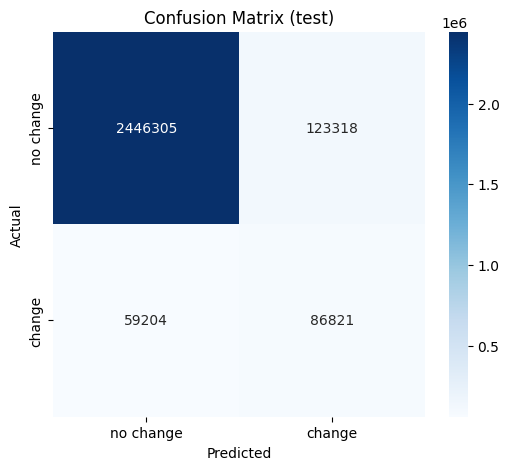

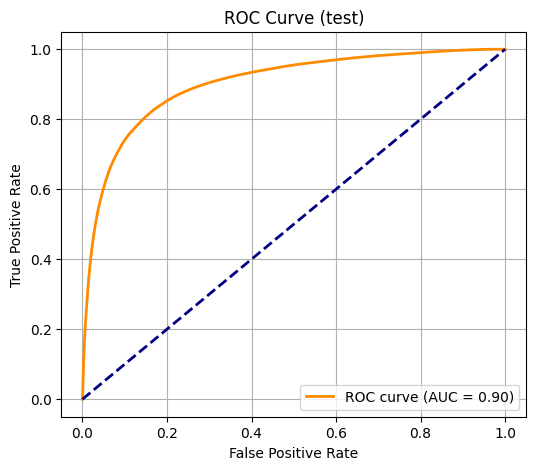

131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

📊 Classification Report (train set):
              precision    recall  f1-score   support

   no change       0.97      0.97      0.97   3826130
      change       0.76      0.74      0.75    450094

    accuracy                           0.95   4276224
   macro avg       0.87      0.86      0.86   4276224
weighted avg       0.95      0.95      0.95   4276224

Confusion Matrix:
[[3721751  104379]
 [ 117604  332490]]

✅ Accuracy: 0.9481, Precision: 0.7611, Recall: 0.7387, F1: 0.7497
🧠 ROC AUC: 0.9632


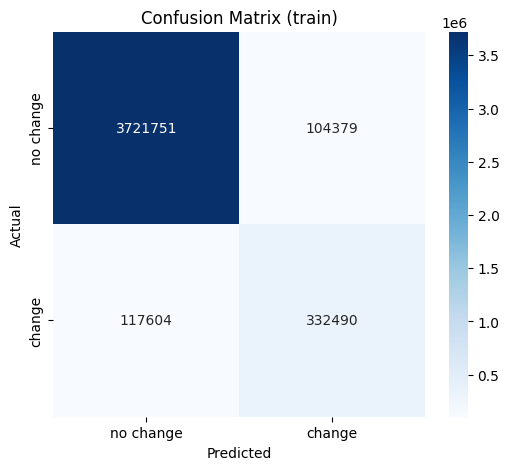

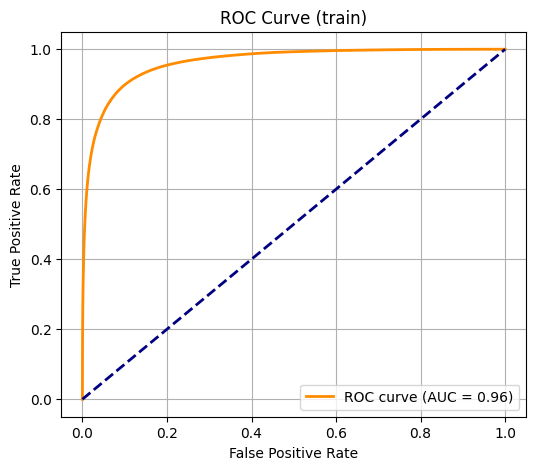

In [ ]:
# Run evaluation on test set
results_test = predict_and_evaluate(model, test_triplets, split_name="test")

# Run evaluation on train set (optional)
results_train = predict_and_evaluate(model, train_triplets, split_name="train")

# Final Improvements

In [ ]:
import segmentation_models as sm
from segmentation_models.losses import DiceLoss, BinaryFocalLoss

# Combine Dice + Focal (or use only one if needed)
dice_loss = DiceLoss(class_weights=np.array([0.2, 0.8]))  # bias toward change class
binaryfocal_loss = BinaryFocalLoss(alpha=0.25, gamma=2.0)  # focus on hard examples

combined_loss = dice_loss + binaryfocal_loss

model.compile(
    optimizer='adam',
    loss=combined_loss,
    metrics=[sm.metrics.iou_score]
)

In [ ]:
import albumentations as A
from tensorflow.keras.utils import Sequence
import cv2

class AugmentedDataset(Sequence):
    def __init__(self, x1, x2, y, batch_size=16, augment=True):
        self.x1 = x1
        self.x2 = x2
        self.y = y
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(x1))
        self.transform = A.Compose([
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.RandomRotate90(),
            A.RandomBrightnessContrast(),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
        ])

    def __len__(self):
        return int(np.ceil(len(self.x1) / self.batch_size))

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        x1_batch = self.x1[batch_idx]
        x2_batch = self.x2[batch_idx]
        y_batch = self.y[batch_idx]

        batch_input = []
        batch_mask = []

        for i in range(len(x1_batch)):
            if self.augment:
                augmented = self.transform(image=np.concatenate([x1_batch[i], x2_batch[i]], axis=-1), mask=y_batch[i])
                x_aug = augmented['image']
                m_aug = augmented['mask']
                x = x_aug
            else:
                x = np.concatenate([x1_batch[i], x2_batch[i]], axis=-1)
                m_aug = y_batch[i]

            batch_input.append(x)
            batch_mask.append(m_aug)

        return np.array(batch_input), np.expand_dims(np.array(batch_mask), -1)


# cross-validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
import segmentation_models as sm
import os

# Configure Segmentation Models
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load your dataset triplets (use your existing data loading logic)
# train_triplets = dataset_from_folder(...)

# Dummy example, replace with your real data
# train_triplets = (im1_train, im2_train, labels_train) with shapes:
# (1044, 64, 64, 3), (1044, 64, 64, 3), (1044, 64, 64, 1)

def keras_dataset_differencingPixels(triplets):
    im1, im2, labels = triplets
    x = im1 - im2  # (B, H, W, 3)
    x = x.astype(np.float32)
    y = labels.astype(np.float32)
    return x, y

# Preprocessing
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

x_data, y_data = keras_dataset_differencingPixels(train_triplets)
x_data = preprocess_input(x_data)

# Create stratification labels for balancing (based on % changed pixels)
change_ratio = np.mean(y_data.reshape(y_data.shape[0], -1), axis=1)
stratify_labels = (change_ratio > 0.01).astype(int)  # binary: change vs no-change

# K-Fold Cross-Validation
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(x_data, stratify_labels)):
    print(f"\n🔁 Fold {fold + 1}/{N_SPLITS}")

    x_train_fold, y_train_fold = x_data[train_idx], y_data[train_idx]
    x_val_fold, y_val_fold = x_data[val_idx], y_data[val_idx]

    # Define model
    model = sm.Unet(
        BACKBONE,
        encoder_weights='imagenet',
        classes=1,
        activation='sigmoid',
        input_shape=(64, 64, 3)
    )
    model.compile(
        optimizer='Adam',
        loss=sm.losses.bce_jaccard_loss,
        metrics=[sm.metrics.iou_score, tf.keras.metrics.AUC()]
    )

    # Train
    history = model.fit(
        x_train_fold, y_train_fold,
        validation_data=(x_val_fold, y_val_fold),
        epochs=20,
        batch_size=16,
        verbose=1
    )

    # Predict on validation set
    y_pred = model.predict(x_val_fold)

    # Flatten for sklearn metrics
    y_true_flat = y_val_fold.flatten()
    y_pred_flat = y_pred.flatten()

    # Threshold
    y_pred_bin = (y_pred_flat > 0.5).astype(np.uint8)

    # Metrics
    acc = sklearn.metrics.accuracy_score(y_true_flat, y_pred_bin)
    prec = sklearn.metrics.precision_score(y_true_flat, y_pred_bin)
    rec = sklearn.metrics.recall_score(y_true_flat, y_pred_bin)
    f1 = sklearn.metrics.f1_score(y_true_flat, y_pred_bin)
    auc = sklearn.metrics.roc_auc_score(y_true_flat, y_pred_flat)

    print(f"✅ Fold {fold + 1} -- Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    fold_metrics.append((acc, prec, rec, f1, auc))

# Average scores
accs, precs, recs, f1s, aucs = zip(*fold_metrics)
print("\n📊 Cross-Validation Summary:")
print(f"Avg Accuracy:  {np.mean(accs):.4f}")
print(f"Avg Precision: {np.mean(precs):.4f}")
print(f"Avg Recall:    {np.mean(recs):.4f}")
print(f"Avg F1 Score:  {np.mean(f1s):.4f}")
print(f"Avg AUC:       {np.mean(aucs):.4f}")



🔁 Fold 1/5
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 530ms/step - auc: 0.6871 - iou_score: 0.1299 - loss: 1.3577 - val_auc: 0.4898 - val_iou_score: 0.0243 - val_loss: 2.4797
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - auc: 0.8564 - iou_score: 0.2752 - loss: 0.9751 - val_auc: 0.5000 - val_iou_score: 4.0588e-09 - val_loss: 2.6999
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - auc: 0.8972 - iou_score: 0.3523 - loss: 0.8757 - val_auc: 0.5213 - val_iou_score: 0.0349 - val_loss: 1.3423
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - auc: 0.9132 - iou_score: 0.3897 - loss: 0.8245 - val_auc: 0.4938 - val_iou_score: 0.0273 - val_loss: 1.3831
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.9257 - iou_score: 0.4368 - loss: 0.7651 - val_auc: 0.5017 - val_iou_score: 0.0161 - val_loss: 1.4464
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.9451 - iou_score: 0.5052 - loss: 0.6648 - val_auc: 0.4949 - val_iou_score: 0.0276 - val_loss: 2.9333
Epoch 7/20
53/5

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 534ms/step
✅ Fold 3 -- Acc: 0.9101, Prec: 0.8529, Rec: 0.0953, F1: 0.1715, AUC: 0.7843

🔁 Fold 4/5
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 469ms/step - auc_3: 0.6961 - iou_score: 0.1315 - loss: 1.3839 - val_auc_3: 0.4996 - val_iou_score: 0.0128 - val_loss: 2.7497
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc_3: 0.8545 - iou_score: 0.2685 - loss: 0.9953 - val_auc_3: 0.5003 - val_iou_score: 0.0159 - val_loss: 1.5734
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - auc_3: 0.8980 - iou_score: 0.3558 - loss: 0.8760 - val_auc_3: 0.4861 - val_iou_score: 0.0591 - val_loss: 2.9767
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - auc_3: 0.8950 - iou_score: 0.3602 - loss: 0.8815 - val_auc_3: 0.4980 - val_iou_score: 0.0068 - val_loss: 1.5699
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - auc_3: 0.9172 - iou_score: 0.4099 - loss: 0.8057 - val_auc_3: 0.5198 - val_iou_score: 0.1051 - val_loss: 8.2271
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 641ms/step
✅ Fold 4 -- Acc: 0.8940, Prec: 0.8241, Rec: 0.0377, F1: 0.0720, AUC: 0.7141

🔁 Fold 5/5
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 66s 430ms/step - auc_4: 0.6999 - iou_score: 0.1381 - loss: 1.3409 - val_auc_4: 0.4996 - val_iou_score: 0.0772 - val_loss: 1.3266
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - auc_4: 0.8885 - iou_score: 0.3140 - loss: 0.9184 - val_auc_4: 0.4959 - val_iou_score: 0.0507 - val_loss: 1.3319
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - auc_4: 0.9067 - iou_score: 0.3645 - loss: 0.8560 - val_auc_4: 0.5030 - val_iou_score: 0.0373 - val_loss: 3.1144
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - auc_4: 0.9141 - iou_score: 0.3864 - loss: 0.8272 - val_auc_4: 0.5000 - val_iou_score: 5.8670e-05 - val_loss: 2.6210
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - auc_4: 0.9247 - iou_score: 0.4304 - loss: 0.7735 - val_auc_4: 0.5059 - val_iou_score: 0.1020 - val_loss: 9.8010
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 6

In [11]:
# ⬇️ Install and import dependencies
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import segmentation_models as sm
sm.set_framework('tf.keras')
K.set_image_data_format('channels_last')

# ✅ Define constants
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
EPOCHS = 10
BATCH_SIZE = 16
KFOLDS = 5
VISUALIZE = False  # Set True for random predictions display

# ✅ Load your data (replace with your real loading logic)
# Assuming `train_triplets` = (im1, im2, labels)
# Shape: (N, 64, 64, 3) for im1, im2 and (N, 64, 64, 1) for labels
# Example: train_triplets = dataset_from_folder(train_cities, train_dir, overlap_for_tiling=..., filter_on=...)
im1, im2, labels = train_triplets
X_data = im1 - im2
X_data = preprocess_input(X_data.astype(np.float32))
Y_data = labels.astype(np.float32)

# ✅ Define metric calculation functions
def evaluate_predictions(preds, gts, threshold=0.5):
    preds_bin = (preds >= threshold).astype(np.uint8)
    y_true = gts.flatten()
    y_pred = preds.flatten()
    y_pred_bin = preds_bin.flatten()

    precision = sklearn.metrics.precision_score(y_true, y_pred_bin)
    recall = sklearn.metrics.recall_score(y_true, y_pred_bin)
    f1 = sklearn.metrics.f1_score(y_true, y_pred_bin)
    acc = sklearn.metrics.accuracy_score(y_true, y_pred_bin)
    auc = sklearn.metrics.roc_auc_score(y_true, y_pred)

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred_bin)
    report = sklearn.metrics.classification_report(y_true, y_pred_bin, target_names=["no change", "change"])

    print("📊 Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)
    print(f"✅ Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"🧠 ROC AUC: {auc:.4f}")
    return acc, precision, recall, f1, auc

# ✅ Create model builder
def build_model():
    model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(64, 64, 3), classes=1, activation='sigmoid')
    model.compile(
        optimizer='adam',
        loss=sm.losses.bce_jaccard_loss,
        metrics=[
            sm.metrics.iou_score,
            keras.metrics.AUC(name="auc")
        ]
    )
    return model

# ✅ Run k-fold cross-validation
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)
results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
    print(f"\n🔁 Fold {fold+1}/{KFOLDS}")

    x_train, y_train = X_data[train_idx], Y_data[train_idx]
    x_val, y_val = X_data[val_idx], Y_data[val_idx]

    model = build_model()
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    preds = model.predict(x_val, batch_size=BATCH_SIZE)
    acc, prec, rec, f1, auc = evaluate_predictions(preds, y_val)

    results.append([acc, prec, rec, f1, auc])

    if VISUALIZE:
        idx = np.random.randint(0, len(x_val))
        plt.figure(figsize=(10, 2))
        plt.subplot(1, 4, 1); plt.imshow((x_val[idx] + 1) / 2); plt.title("Input")
        plt.subplot(1, 4, 2); plt.imshow(y_val[idx].squeeze()); plt.title("Ground Truth")
        plt.subplot(1, 4, 3); plt.imshow(preds[idx].squeeze()); plt.title("Prediction")
        plt.subplot(1, 4, 4); plt.imshow(preds[idx].squeeze() > 0.5); plt.title("Thresholded")
        plt.show()

# ✅ Final Results
results = np.array(results)
print("\n📊 Cross-Validation Summary:")
print("Avg Accuracy: ", round(results[:,0].mean(), 4))
print("Avg Precision:", round(results[:,1].mean(), 4))
print("Avg Recall:   ", round(results[:,2].mean(), 4))
print("Avg F1 Score: ", round(results[:,3].mean(), 4))
print("Avg AUC:      ", round(results[:,4].mean(), 4))

Segmentation Models: using `keras` framework.

🔁 Fold 1/5
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - auc: 0.6966 - iou_score: 0.1252 - loss: 1.4821 - val_auc: 0.4994 - val_iou_score: 0.0057 - val_loss: 2.8823
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - auc: 0.8596 - iou_score: 0.2835 - loss: 0.9664 - val_auc: 0.4805 - val_iou_score: 0.0139 - val_loss: 1.5645
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - auc: 0.9031 - iou_score: 0.3515 - loss: 0.8620 - val_auc: 0.4958 - val_iou_score: 0.0178 - val_loss: 1.5231
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - auc: 0.9040 - iou_score: 0.3558 - loss: 0.8597 - val_auc: 0.5094 - val_iou_score: 0.0118 - val_loss: 1.5092
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - auc: 0.9297 - iou_score: 0.4420 - loss: 0.7480 - val_auc: 0.5073 - val_iou_score: 0.0054 - val_loss: 1.6113
Epoch 6/10
13/53 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - auc: 0.9360 - iou_score: 0.4866 -

KeyboardInterrupt: 